In [1]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import igraph as ig
import math
from math import radians, sin, cos, sqrt, atan2
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from itertools import combinations

In [2]:
outbreaks_data = pd.read_csv('Outbreaks.csv')
geo_data =  pd.read_csv('country-coord.csv')
geo_data.head()

Country iso2 iso3  Numeric code      lat    lon
0     Afghanistan   AF  AFG           4.0  33.0000   65.0
1         Albania   AL  ALB           8.0  41.0000   20.0
2         Algeria   DZ  DZA          12.0  28.0000    3.0
3  American Samoa   AS  ASM          16.0 -14.3333 -170.0
4         Andorra   AD  AND          20.0  42.5000    1.6

In [3]:
simplified_data = outbreaks_data[['Country', 'iso3', 'Year', 'Disease']].copy()
simplified_data.head()

Country iso3  Year                                            Disease
0  Afghanistan  AFG  2000               Unspecified viral haemorrhagic fever
1  Afghanistan  AFG  2002  Infectious gastroenteritis or colitis without ...
2  Afghanistan  AFG  1998                                            Cholera
3  Afghanistan  AFG  1999                  Severe acute respiratory syndrome
4  Afghanistan  AFG  2000                                            Cholera

In [32]:
data_simplified_cleaned = simplified_data.drop_duplicates()

data_simplified_cleaned.shape

(2221, 4)

In [33]:
disease_frequency = data_simplified_cleaned['Disease'].value_counts().reset_index()
disease_frequency.columns = ['Disease', 'Frequency']
print(disease_frequency)

                                              Disease  Frequency
0                                            COVID-19        659
1    Influenza due to identified zoonotic or pande...        409
2                                             Cholera        167
3                    Acute poliomyelitis, unspecified        112
4                           Yellow fever, unspecified        104
..                                                ...        ...
65     Arthropod-borne viral fever, virus unspecified          1
66                   Enteroviral vesicular stomatitis          1
67  Epidemic louse-borne typhus fever due to Ricke...          1
68             Creutzfeldt-Jakob disease, unspecified          1
69                             Pseudomonas aeruginosa          1

[70 rows x 2 columns]


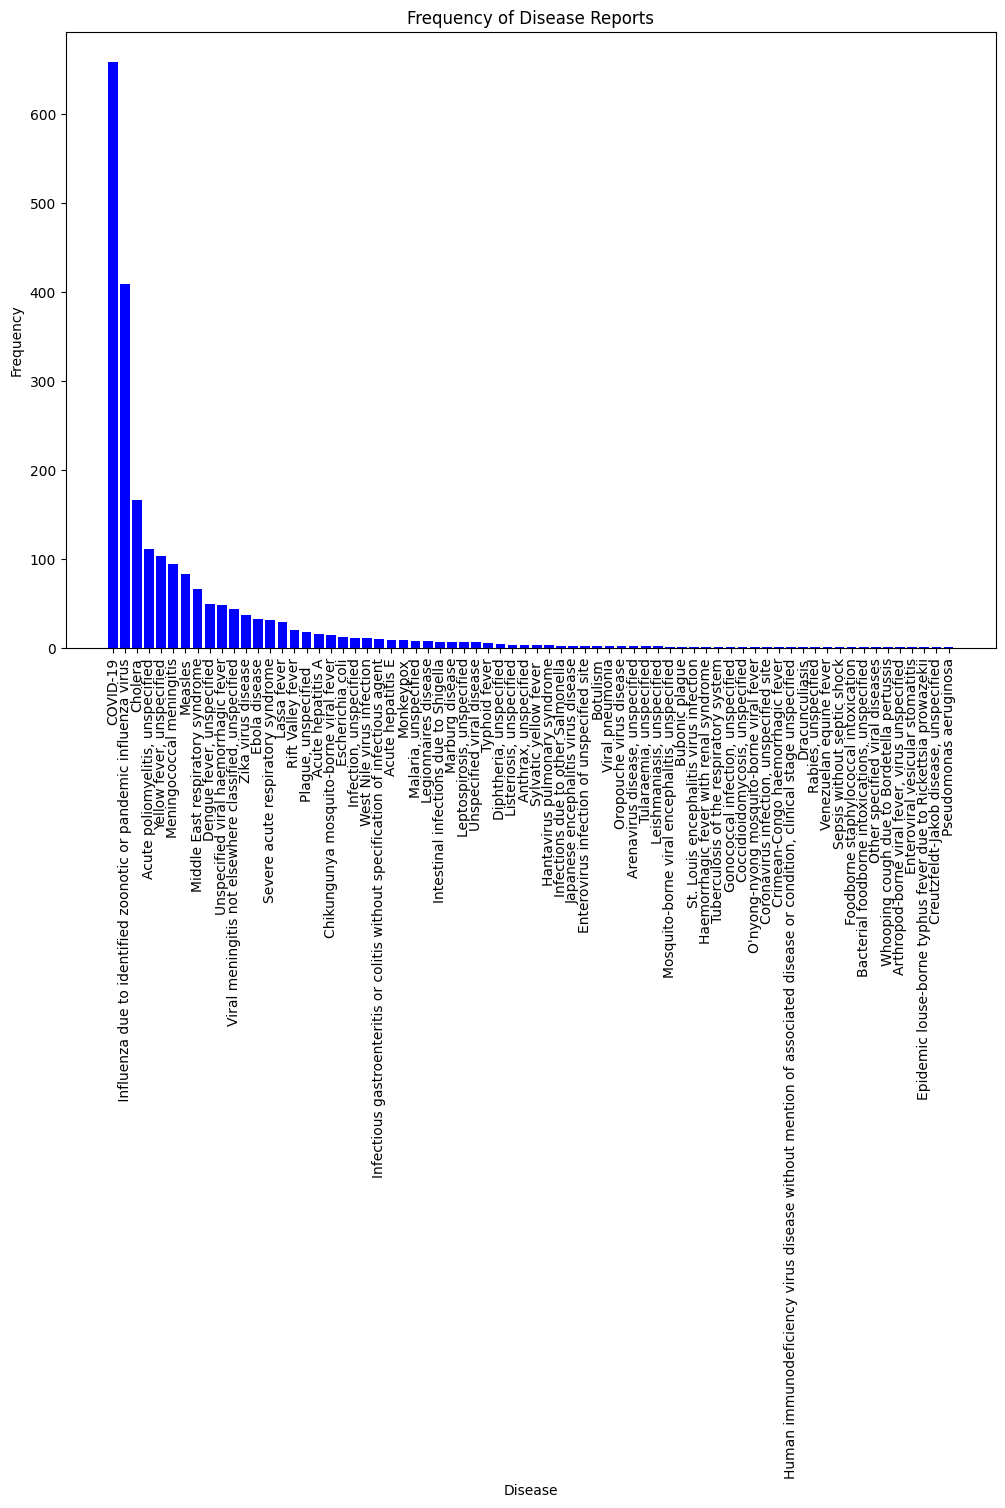

In [34]:
plt.figure(figsize=(12, 8))
plt.bar(disease_frequency['Disease'], disease_frequency['Frequency'], color='b')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Frequency of Disease Reports')
plt.xticks(rotation=90)  # Rotate the disease names for better readability
plt.show()

Data Aggregration: Aggregate data by 'Country' and 
Disease to see how many times each country reported each disease. 

In [35]:
country_disease_counts = data_simplified_cleaned.groupby('Country').size().reset_index(name='Disease')
print(country_disease_counts.sort_values(by='Disease', ascending=False))

                              Country  Disease
45   Congo Democratic Republic of the       57
154                           Nigeria       44
221          United States of America       37
200                             Sudan       32
39                               Chad       31
..                                ...      ...
147                             Nauru        1
90                           Holy See        1
155                              Niue        1
216                            Tuvalu        1
124                             Macao        1

[233 rows x 2 columns]


In [36]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Merge distance data with the world GeoDataFrame on the 'iso3' code
merged_data = world.merge(data_simplified_cleaned, left_on='iso_a3', right_on='iso3', how='left')

/var/folders/3n/6lwyw3ds0g1btn8kl6pjc7880000gn/T/ipykernel_70220/3858676820.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [37]:
diseases_by_country = data_simplified_cleaned.groupby('iso3')['Disease'].nunique().reset_index()
diseases_by_country.rename(columns={'Disease': 'UniqueDiseases'}, inplace=True)
merged_data = world.merge(diseases_by_country, left_on='iso_a3', right_on='iso3', how='left')


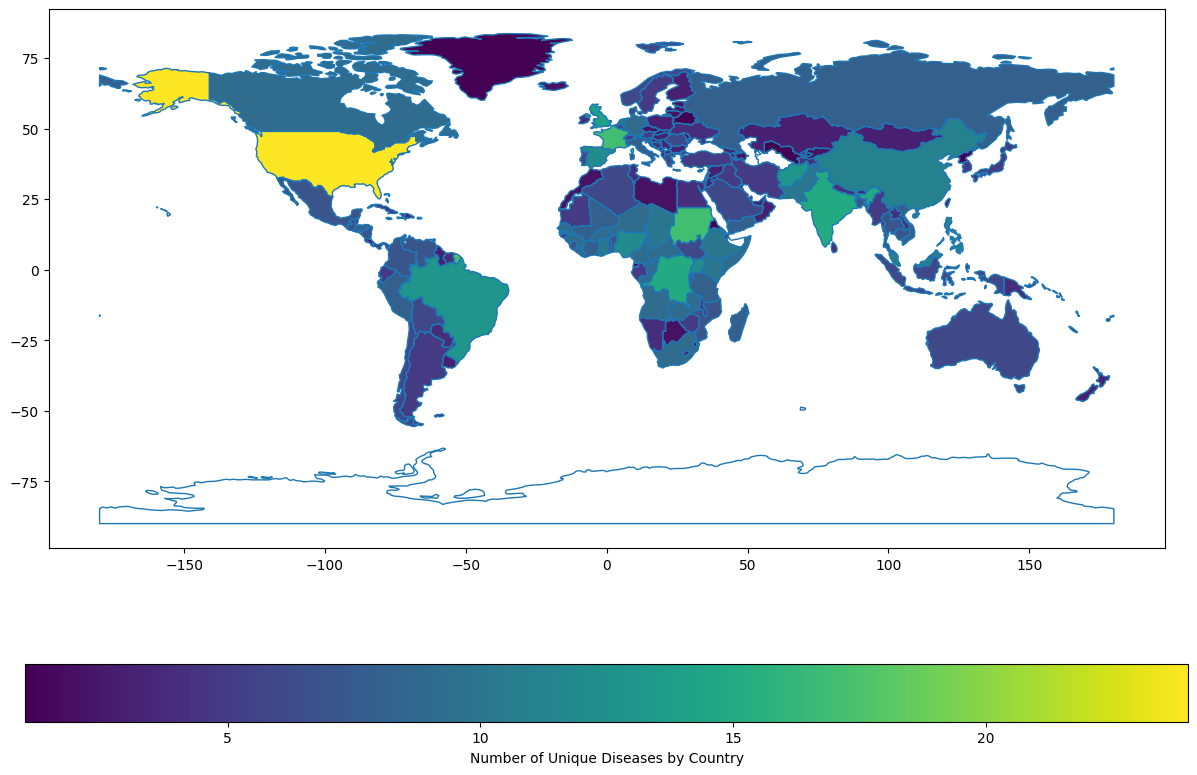

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.boundary.plot(ax=ax, linewidth=1)
merged_data.plot(column='UniqueDiseases', ax=ax, legend=True,
                 legend_kwds={'label': "Number of Unique Diseases by Country",
                              'orientation': "horizontal"})

plt.show()

In [39]:
relationship_data = data_simplified_cleaned.groupby(['Country', 'Year', 'Disease', 'iso3']).size().reset_index(name='Count')
relationship_data

Country  Year                               Disease iso3  Count
0     Afghanistan  1998                               Cholera  AFG      1
1     Afghanistan  1998  Unspecified viral haemorrhagic fever  AFG      1
2     Afghanistan  1999      Acute poliomyelitis, unspecified  AFG      1
3     Afghanistan  1999                               Cholera  AFG      1
4     Afghanistan  1999                Infection, unspecified  AFG      1
...           ...   ...                                   ...  ...    ...
2216     Zimbabwe  2009                               Cholera  ZWE      1
2217     Zimbabwe  2018                               Cholera  ZWE      1
2218     Zimbabwe  2020                              COVID-19  ZWE      1
2219     Zimbabwe  2021                              COVID-19  ZWE      1
2220     Zimbabwe  2022                              COVID-19  ZWE      1

[2221 rows x 5 columns]

In [40]:
def find_shared_diseases(data):
    grouped = data.groupby(['Disease', 'Year'])

    edges = []
    
    for (disease, year), group in grouped:
        countries = list(group['iso3'])
        # Generate all possible pairs of countries within each group
        for pair in itertools.combinations(countries, 2):
            edges.append((pair[0], pair[1], {'disease': disease, 'year': year}))  
    return edges


edges = find_shared_diseases(relationship_data)

G = nx.Graph()


for edge in edges:
    country1, country2, attributes = edge
    G.add_edge(country1, country2, **attributes)


In [41]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Prepare to display the top 5 countries based on each centrality measure
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

top_degree, top_closeness, top_betweenness

([('CHN', 0.9956896551724138),
  ('USA', 0.9956896551724138),
  ('FRA', 0.9956896551724138),
  ('DEU', 0.9956896551724138),
  ('RUS', 0.9956896551724138),
  ('VNM', 0.9956896551724138),
  ('MMR', 0.9956896551724138),
  ('AUS', 0.9956896551724138),
  ('BRA', 0.9956896551724138),
  ('COL', 0.9956896551724138),
  ('FJI', 0.9956896551724138),
  ('MYS', 0.9956896551724138),
  ('PHL', 0.9956896551724138),
  ('SDN', 0.9956896551724138),
  ('VEN', 0.9956896551724138),
  ('CAN', 0.9913793103448276),
  ('ISR', 0.9913793103448276),
  ('JPN', 0.9913793103448276),
  ('MDG', 0.9913793103448276),
  ('IND', 0.9913793103448276)],
 [('CHN', 0.9957081545064378),
  ('USA', 0.9957081545064378),
  ('FRA', 0.9957081545064378),
  ('DEU', 0.9957081545064378),
  ('RUS', 0.9957081545064378),
  ('VNM', 0.9957081545064378),
  ('MMR', 0.9957081545064378),
  ('AUS', 0.9957081545064378),
  ('BRA', 0.9957081545064378),
  ('COL', 0.9957081545064378),
  ('FJI', 0.9957081545064378),
  ('MYS', 0.9957081545064378),
  ('PHL

In [42]:
# For degree centrality
lowest_degree = sorted(degree_centrality.items(), key=lambda x: x[1])[:10]

# For closeness centrality
lowest_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1])[:5]

# For betweenness centrality
lowest_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1])[:5]

(lowest_degree, lowest_closeness, lowest_betweenness)

([('XXK', 0.034482758620689655),
  ('TWN', 0.15948275862068964),
  ('MAC', 0.17672413793103448),
  ('PRK', 0.8275862068965517),
  ('FSM', 0.8275862068965517),
  ('NAM', 0.8275862068965517),
  ('NRU', 0.8275862068965517),
  ('TUV', 0.8275862068965517),
  ('HKG', 0.8836206896551724),
  ('VAT', 0.9353448275862069)],
 [('XXK', 0.5087719298245614),
  ('TWN', 0.5433255269320844),
  ('MAC', 0.5484633569739953),
  ('PRK', 0.8529411764705882),
  ('FSM', 0.8529411764705882)],
 [('PRK', 0.0), ('FSM', 0.0), ('NAM', 0.0), ('NRU', 0.0), ('TUV', 0.0)])

## Temporal Analysis

## Time-Sliced Networks

In [43]:
yearly_networks = {}
network_metrics = {}

for year in sorted(data_simplified_cleaned['Year'].unique()):
    yearly_data = data_simplified_cleaned[data_simplified_cleaned['Year'] == year]
    G_year = nx.Graph()
    G_year.add_nodes_from(yearly_data['iso3'].unique())
    
    for disease in yearly_data['Disease'].unique():
        countries_with_disease = yearly_data[yearly_data['Disease'] == disease]['iso3'].tolist()
        for i in range(len(countries_with_disease)):
            for j in range(i + 1, len(countries_with_disease)):
                G_year.add_edge(countries_with_disease[i], countries_with_disease[j])
    
    yearly_networks[year] = G_year
    network_metrics[year] = {
        'degree': nx.degree_centrality(G_year),
        'betweenness': nx.betweenness_centrality(G_year),
        'closeness': nx.closeness_centrality(G_year),
        'eigenvector': nx.eigenvector_centrality(G_year)
    }

yearly_networks, network_metrics


({1996: <networkx.classes.graph.Graph at 0x285135f50>,
  1997: <networkx.classes.graph.Graph at 0x287062250>,
  1998: <networkx.classes.graph.Graph at 0x1773676d0>,
  1999: <networkx.classes.graph.Graph at 0x17738e410>,
  2000: <networkx.classes.graph.Graph at 0x1772c3dd0>,
  2001: <networkx.classes.graph.Graph at 0x285137c50>,
  2002: <networkx.classes.graph.Graph at 0x16d841390>,
  2003: <networkx.classes.graph.Graph at 0x177329b50>,
  2004: <networkx.classes.graph.Graph at 0x1772d8490>,
  2005: <networkx.classes.graph.Graph at 0x16d956150>,
  2006: <networkx.classes.graph.Graph at 0x1773409d0>,
  2007: <networkx.classes.graph.Graph at 0x288198450>,
  2008: <networkx.classes.graph.Graph at 0x285f5f690>,
  2009: <networkx.classes.graph.Graph at 0x283882cd0>,
  2010: <networkx.classes.graph.Graph at 0x1772d9150>,
  2011: <networkx.classes.graph.Graph at 0x16d950e50>,
  2012: <networkx.classes.graph.Graph at 0x28805d290>,
  2013: <networkx.classes.graph.Graph at 0x28656b5d0>,
  2014: <n

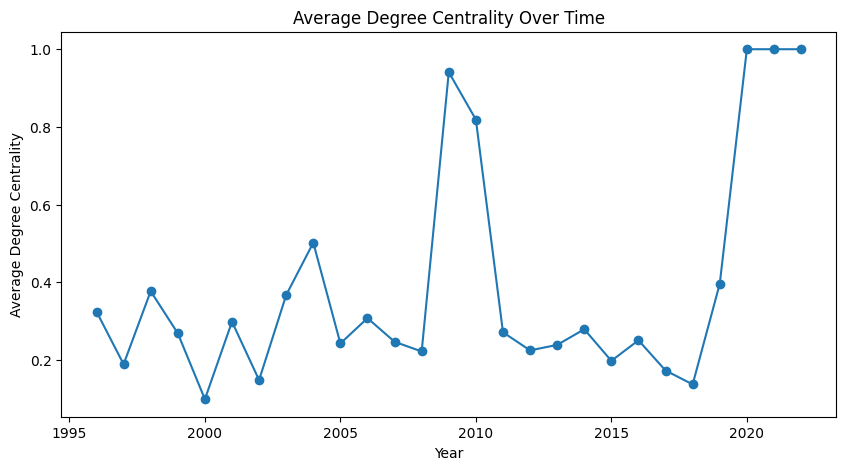

In [44]:
#Plotting average degree centrality over time
years = sorted(network_metrics.keys())
avg_degree = [sum(metrics['degree'].values()) / len(metrics['degree']) for metrics in network_metrics.values()]
avg_betweenness = [np.mean(list(metrics['betweenness'].values())) for year, metrics in network_metrics.items()]
avg_closeness = [np.mean(list(metrics['closeness'].values())) for year, metrics in network_metrics.items()]
avg_eigenvector = [np.mean(list(metrics['eigenvector'].values())) for year, metrics in network_metrics.items()]

plt.figure(figsize=(10, 5))
plt.plot(years, avg_degree, marker='o')
plt.title('Average Degree Centrality Over Time')
plt.xlabel('Year')
plt.ylabel('Average Degree Centrality')
plt.grid(False)
plt.show()

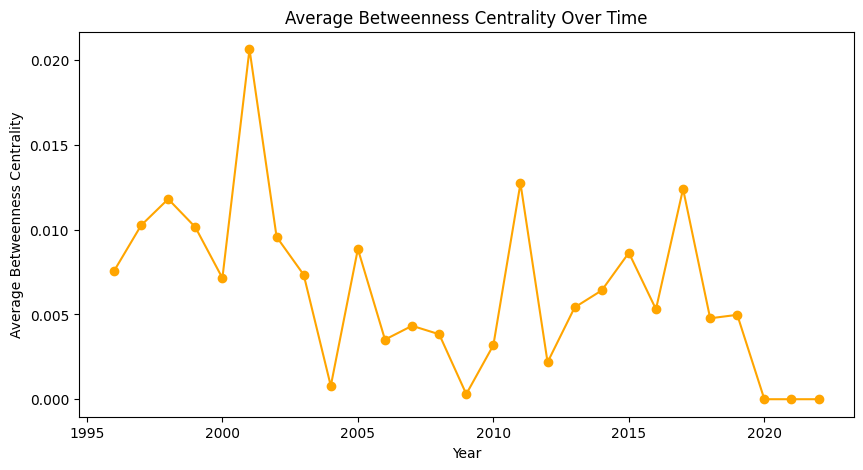

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(years, avg_betweenness, marker='o', linestyle='-', color='orange')
plt.title('Average Betweenness Centrality Over Time')
plt.xlabel('Year')
plt.ylabel('Average Betweenness Centrality')
plt.grid(False)
plt.show()

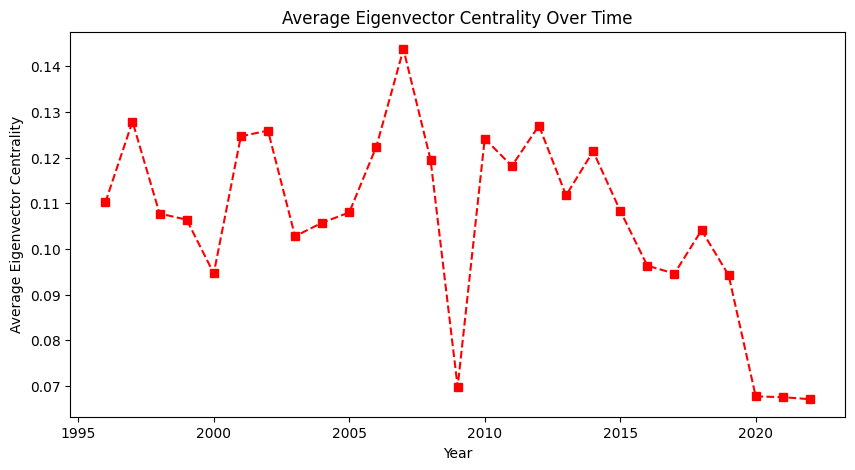

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(years, avg_eigenvector, marker='s', linestyle='--', color='r')
plt.title('Average Eigenvector Centrality Over Time')
plt.xlabel('Year')
plt.ylabel('Average Eigenvector Centrality')
plt.grid(False)
plt.show()

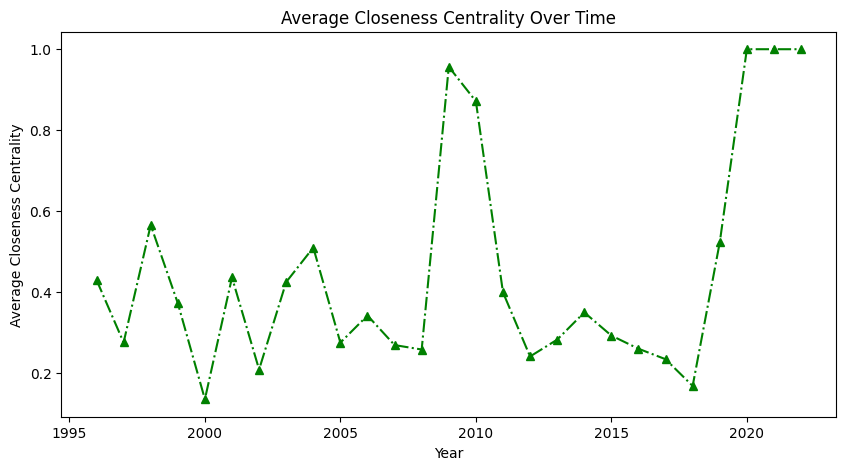

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(years, avg_closeness, marker='^', linestyle='-.', color='g')
plt.title('Average Closeness Centrality Over Time')
plt.xlabel('Year')
plt.ylabel('Average Closeness Centrality')
plt.grid(False)
plt.show()

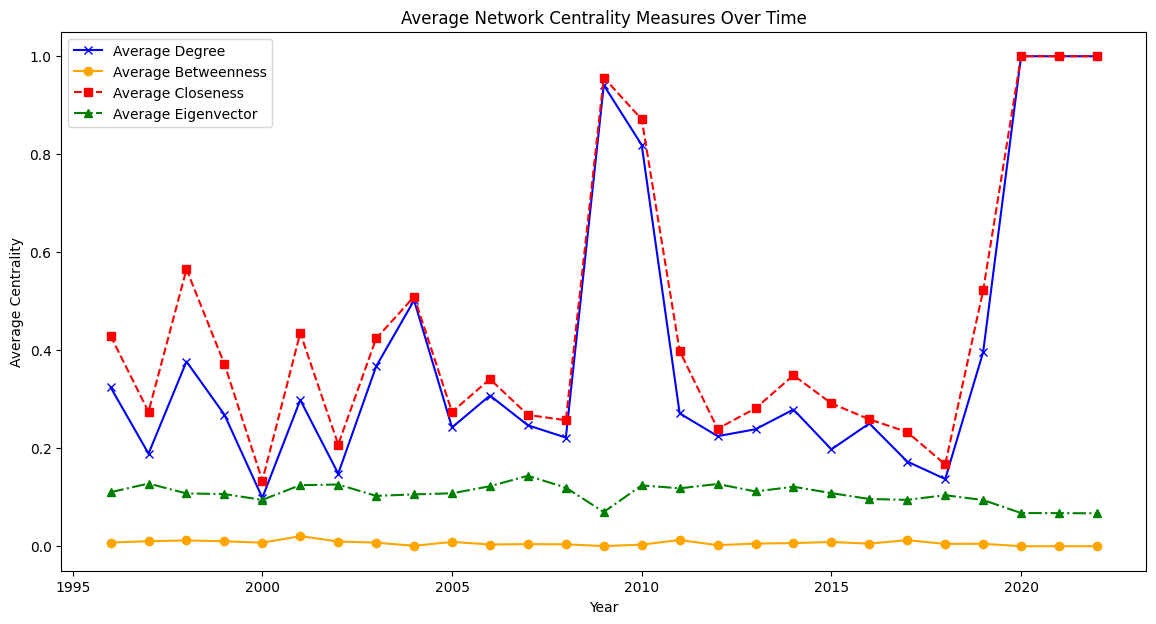

In [48]:
plt.figure(figsize=(14, 7))

# Plotting each centrality
plt.plot(years, avg_degree, marker='x', linestyle='-', color='blue', label='Average Degree')
plt.plot(years, avg_betweenness, marker='o', linestyle='-', color='orange', label='Average Betweenness')
plt.plot(years, avg_closeness, marker='s', linestyle='--', color='r', label='Average Closeness')
plt.plot(years, avg_eigenvector, marker='^', linestyle='-.', color='g', label='Average Eigenvector')
plt.title('Average Network Centrality Measures Over Time')
plt.xlabel('Year')
plt.ylabel('Average Centrality')
plt.legend()
plt.grid(False)
plt.show()

## Temporal Centrality Evolution

We select the countries with the highest degree and betweeness centralities across all the regions to have a representative sample

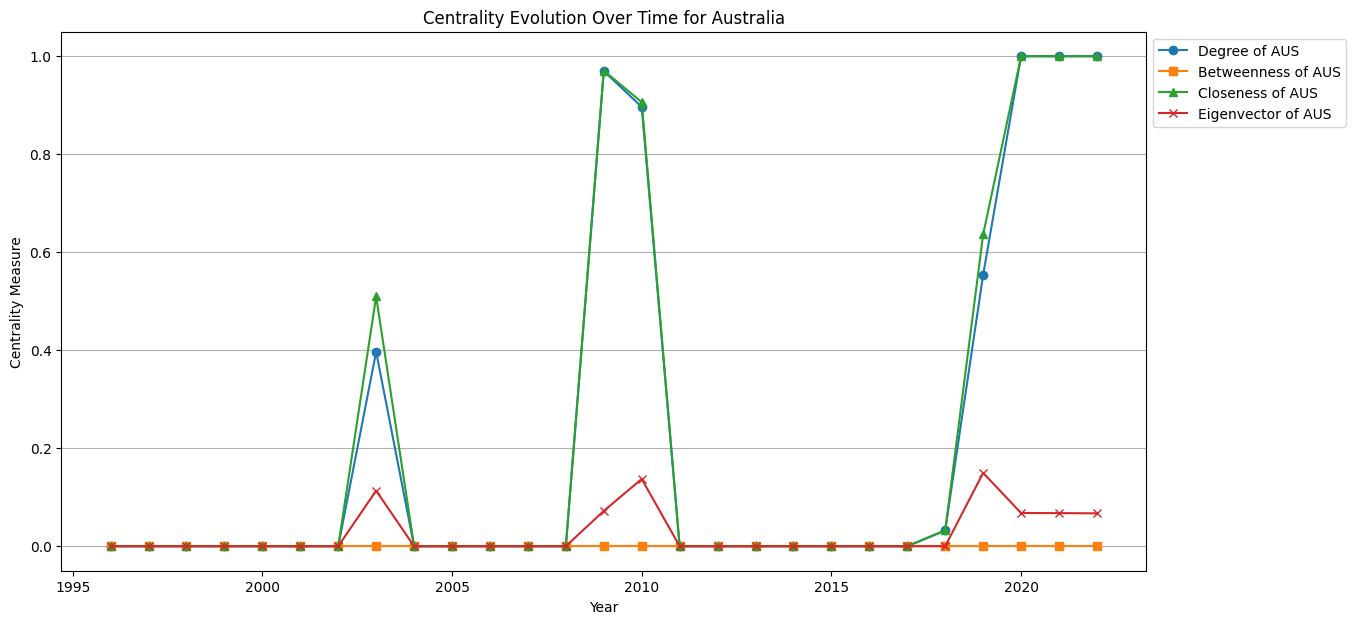

In [49]:
tracked_countries = ['AUS']
tracked_centralities = {country: {'degree': [], 'betweenness': [], 'closeness': [], 'eigenvector': []} for country in tracked_countries}

for year in sorted(yearly_networks.keys()):
    metrics = network_metrics[year]
    for country in tracked_countries:
        if country in metrics['degree']:
            tracked_centralities[country]['degree'].append(metrics['degree'][country])
            tracked_centralities[country]['betweenness'].append(metrics['betweenness'][country])
            tracked_centralities[country]['closeness'].append(metrics['closeness'][country])
            tracked_centralities[country]['eigenvector'].append(metrics['eigenvector'][country])
        else:
            # Handle missing data for a country in a particular year - default to zero
            tracked_centralities[country]['degree'].append(0)
            tracked_centralities[country]['betweenness'].append(0)
            tracked_centralities[country]['closeness'].append(0)
            tracked_centralities[country]['eigenvector'].append(0)

plt.figure(figsize=(14, 7))
years = sorted(yearly_networks.keys())

for country, centralities in tracked_centralities.items():
    plt.plot(years, centralities['degree'], marker='o', label=f'Degree of {country}')
    plt.plot(years, centralities['betweenness'], marker='s', label=f'Betweenness of {country}')
    plt.plot(years, centralities['closeness'], marker='^', label=f'Closeness of {country}')
    plt.plot(years, centralities['eigenvector'], marker='x', label=f'Eigenvector of {country}')

plt.title('Centrality Evolution Over Time for Australia')
plt.xlabel('Year')
plt.ylabel('Centrality Measure')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True, axis = 'y')
plt.show()

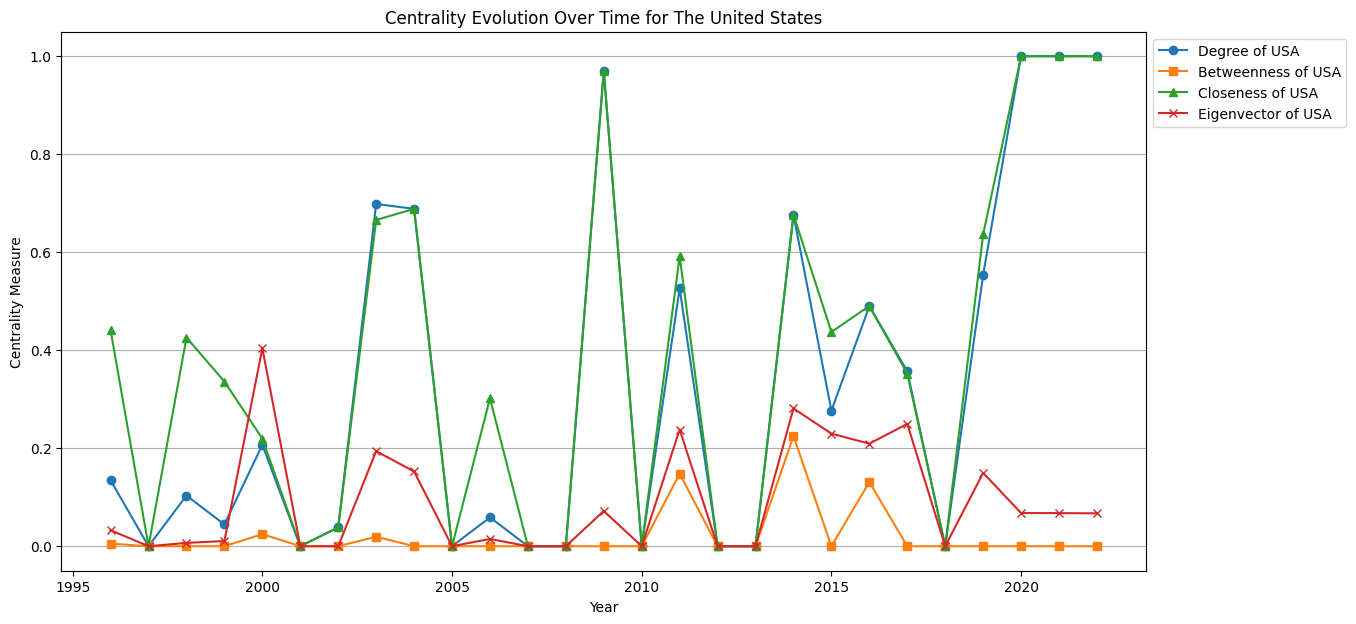

In [50]:
tracked_countries = ['USA']
tracked_centralities = {country: {'degree': [], 'betweenness': [], 'closeness': [], 'eigenvector': []} for country in tracked_countries}

for year in sorted(yearly_networks.keys()):
    metrics = network_metrics[year]
    for country in tracked_countries:
        if country in metrics['degree']:
            tracked_centralities[country]['degree'].append(metrics['degree'][country])
            tracked_centralities[country]['betweenness'].append(metrics['betweenness'][country])
            tracked_centralities[country]['closeness'].append(metrics['closeness'][country])
            tracked_centralities[country]['eigenvector'].append(metrics['eigenvector'][country])
        else:
            # Handle missing data for a country in a particular year - default to zero
            tracked_centralities[country]['degree'].append(0)
            tracked_centralities[country]['betweenness'].append(0)
            tracked_centralities[country]['closeness'].append(0)
            tracked_centralities[country]['eigenvector'].append(0)

plt.figure(figsize=(14, 7))
years = sorted(yearly_networks.keys())

for country, centralities in tracked_centralities.items():
    plt.plot(years, centralities['degree'], marker='o', label=f'Degree of {country}')
    plt.plot(years, centralities['betweenness'], marker='s', label=f'Betweenness of {country}')
    plt.plot(years, centralities['closeness'], marker='^', label=f'Closeness of {country}')
    plt.plot(years, centralities['eigenvector'], marker='x', label=f'Eigenvector of {country}')

plt.title('Centrality Evolution Over Time for The United States')
plt.xlabel('Year')
plt.ylabel('Centrality Measure')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True, axis = 'y')
plt.show()

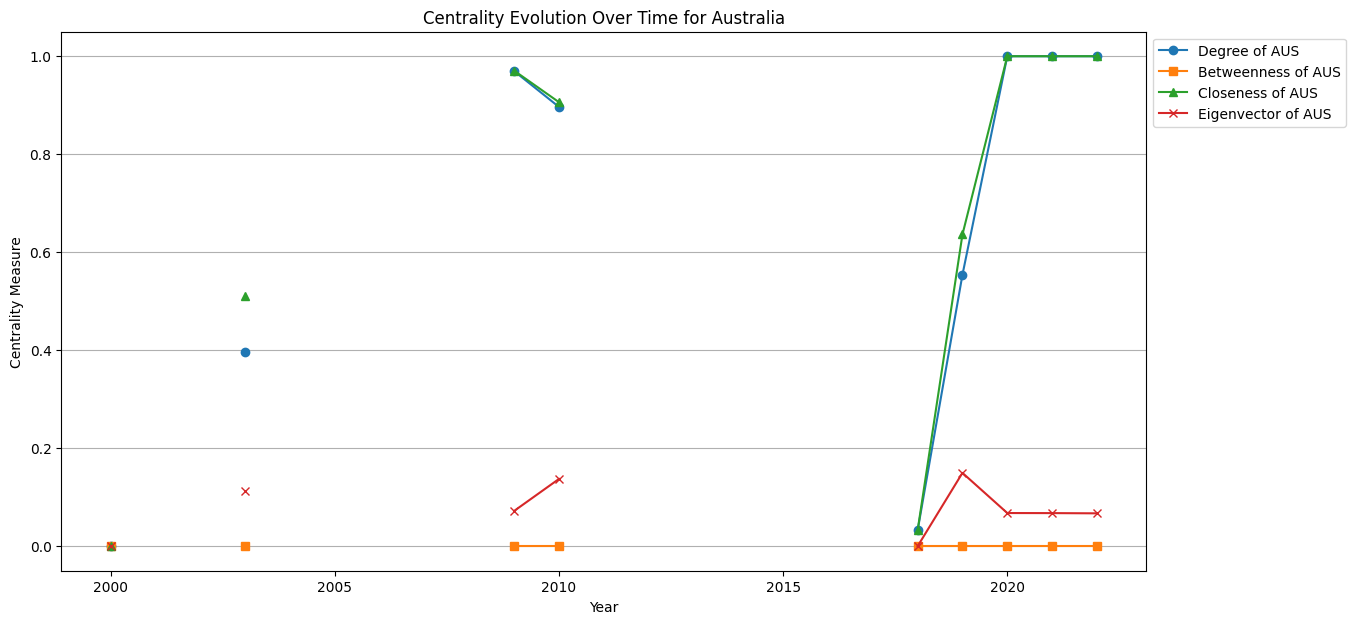

In [51]:
tracked_countries = ['AUS']
tracked_centralities = {country: {'degree': [], 'betweenness': [], 'closeness': [], 'eigenvector': []} for country in tracked_countries}

for year in sorted(yearly_networks.keys()):
    metrics = network_metrics[year]
    for country in tracked_countries:
        if country in metrics['degree']:
            tracked_centralities[country]['degree'].append(metrics['degree'][country])
            tracked_centralities[country]['betweenness'].append(metrics['betweenness'][country])
            tracked_centralities[country]['closeness'].append(metrics['closeness'][country])
            tracked_centralities[country]['eigenvector'].append(metrics['eigenvector'][country])
        else:
            # Use np.nan for years when the country does not appear in the network
            tracked_centralities[country]['degree'].append(np.nan)
            tracked_centralities[country]['betweenness'].append(np.nan)
            tracked_centralities[country]['closeness'].append(np.nan)
            tracked_centralities[country]['eigenvector'].append(np.nan)

plt.figure(figsize=(14, 7))
years = sorted(yearly_networks.keys())

for country, centralities in tracked_centralities.items():
    plt.plot(years, centralities['degree'], marker='o', label=f'Degree of {country}')
    plt.plot(years, centralities['betweenness'], marker='s', label=f'Betweenness of {country}')
    plt.plot(years, centralities['closeness'], marker='^', label=f'Closeness of {country}')
    plt.plot(years, centralities['eigenvector'], marker='x', label=f'Eigenvector of {country}')

plt.title('Centrality Evolution Over Time for Australia')
plt.xlabel('Year')
plt.ylabel('Centrality Measure')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True, axis = 'y')
plt.show()


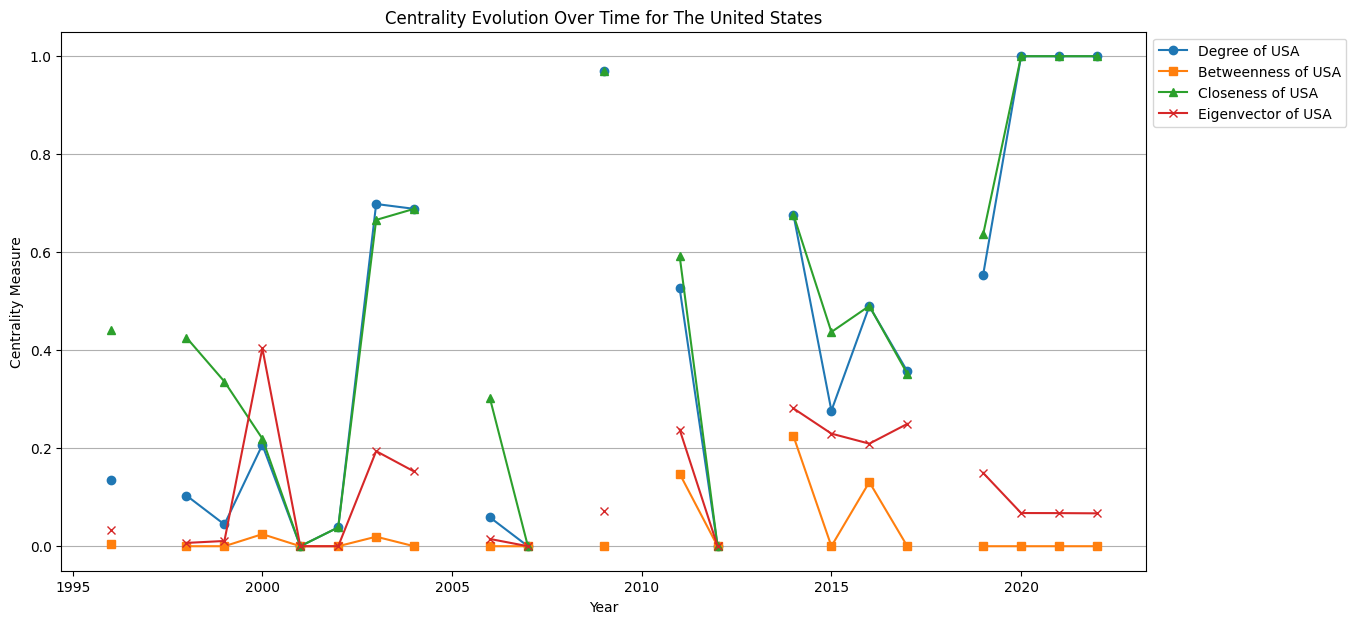

In [52]:
tracked_countries = ['USA']
tracked_centralities = {country: {'degree': [], 'betweenness': [], 'closeness': [], 'eigenvector': []} for country in tracked_countries}

for year in sorted(yearly_networks.keys()):
    metrics = network_metrics[year]
    for country in tracked_countries:
        if country in metrics['degree']:
            tracked_centralities[country]['degree'].append(metrics['degree'][country])
            tracked_centralities[country]['betweenness'].append(metrics['betweenness'][country])
            tracked_centralities[country]['closeness'].append(metrics['closeness'][country])
            tracked_centralities[country]['eigenvector'].append(metrics['eigenvector'][country])
        else:
            # Use np.nan for years when the country does not appear in the network
            tracked_centralities[country]['degree'].append(np.nan)
            tracked_centralities[country]['betweenness'].append(np.nan)
            tracked_centralities[country]['closeness'].append(np.nan)
            tracked_centralities[country]['eigenvector'].append(np.nan)

plt.figure(figsize=(14, 7))
years = sorted(yearly_networks.keys())

for country, centralities in tracked_centralities.items():
    plt.plot(years, centralities['degree'], marker='o', label=f'Degree of {country}')
    plt.plot(years, centralities['betweenness'], marker='s', label=f'Betweenness of {country}')
    plt.plot(years, centralities['closeness'], marker='^', label=f'Closeness of {country}')
    plt.plot(years, centralities['eigenvector'], marker='x', label=f'Eigenvector of {country}')

plt.title('Centrality Evolution Over Time for The United States')
plt.xlabel('Year')
plt.ylabel('Centrality Measure')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True, axis = 'y')
plt.show()

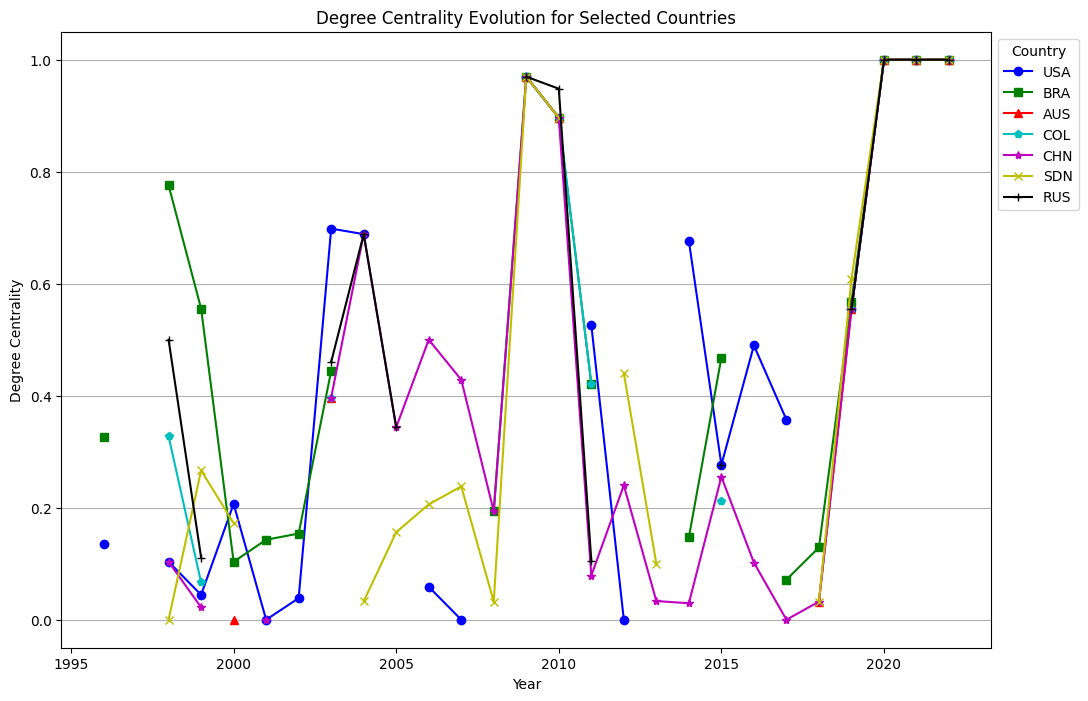

In [53]:
# List of countries to track
tracked_countries = ['USA', 'BRA', 'AUS', 'COL', 'CHN', 'SDN', 'RUS']


tracked_degree_centrality = {country: [] for country in tracked_countries}

for year in sorted(yearly_networks.keys()):
    metrics = network_metrics[year]
    for country in tracked_countries:
        # Use NaN if the country data is missing for the year
        degree_value = metrics['degree'].get(country, np.nan)
        tracked_degree_centrality[country].append(degree_value)

plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  
markers = ['o', 's', '^', 'p', '*', 'x', '+']  

for idx, country in enumerate(tracked_countries):
    plt.plot(sorted(yearly_networks.keys()), tracked_degree_centrality[country], 
             label=f'{country}', marker=markers[idx], color=colors[idx])


plt.title('Degree Centrality Evolution for Selected Countries')
plt.xlabel('Year')
plt.ylabel('Degree Centrality')
plt.legend(title="Country", loc='upper left', bbox_to_anchor=(1, 1)) 
plt.grid(True, axis='y') 
plt.show()

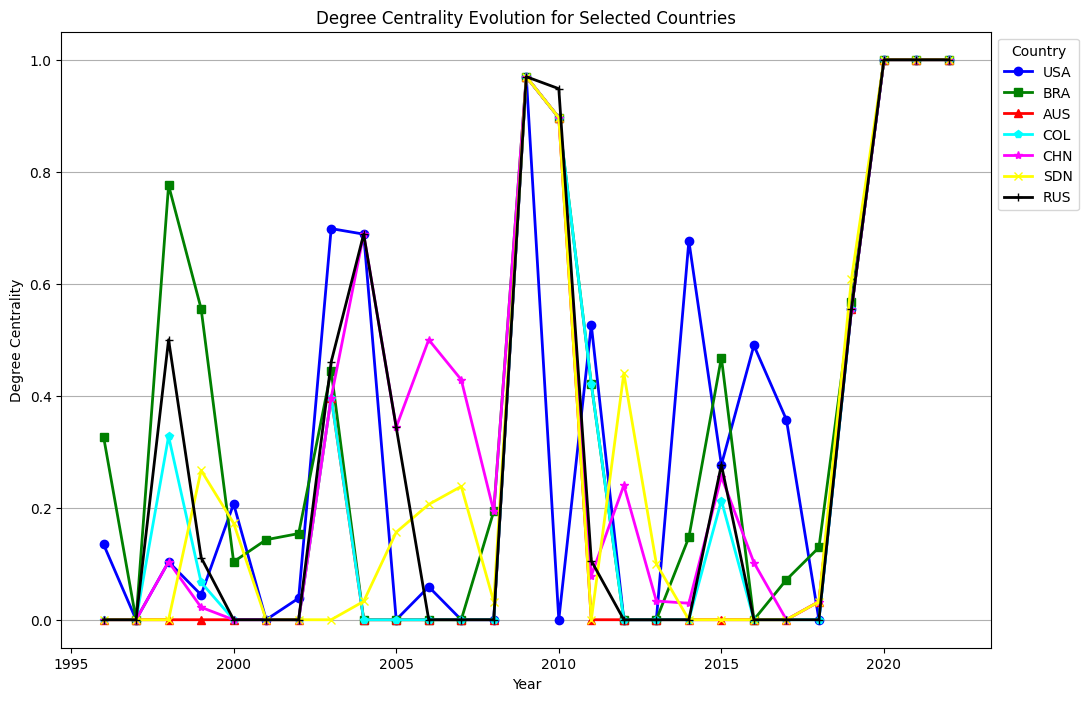

In [54]:
tracked_countries = ['USA', 'BRA', 'AUS', 'COL', 'CHN', 'SDN', 'RUS']
tracked_degree_centrality = {country: [] for country in tracked_countries}

for year in sorted(yearly_networks.keys()):
    metrics = network_metrics[year]
    for country in tracked_countries:
        degree_value = metrics['degree'].get(country, 0) 
        tracked_degree_centrality[country].append(degree_value)
        
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
markers = ['o', 's', '^', 'p', '*', 'x', '+']
for idx, country in enumerate(tracked_countries):
    plt.plot(sorted(yearly_networks.keys()), tracked_degree_centrality[country], 
             label=f'{country}', marker=markers[idx], color=colors[idx], linestyle='-', linewidth=2)
plt.title('Degree Centrality Evolution for Selected Countries')
plt.xlabel('Year')
plt.ylabel('Degree Centrality')
plt.legend(title="Country", loc='upper left', bbox_to_anchor=(1, 1))  
plt.grid(True, axis='y') 
plt.show()


In [55]:
all_years = sorted(data_simplified_cleaned['Year'].unique())
missing_years = []

for year in all_years:
    yearly_data = data_simplified_cleaned[data_simplified_cleaned['Year'] == year]
    
    # Check if 'RUS' is in the countries reported this year
    if 'RUS' not in yearly_data['iso3'].values:
        missing_years.append(year)

print(f"Years with missing data for RUS: {missing_years}")

Years with missing data for RUS: [1996, 1997, 2000, 2001, 2002, 2006, 2007, 2008, 2012, 2013, 2014, 2016, 2017, 2018]


### Year-Specific Analysis

Year with the highest betweeness 2001 and one of the highest degree centrality 2010

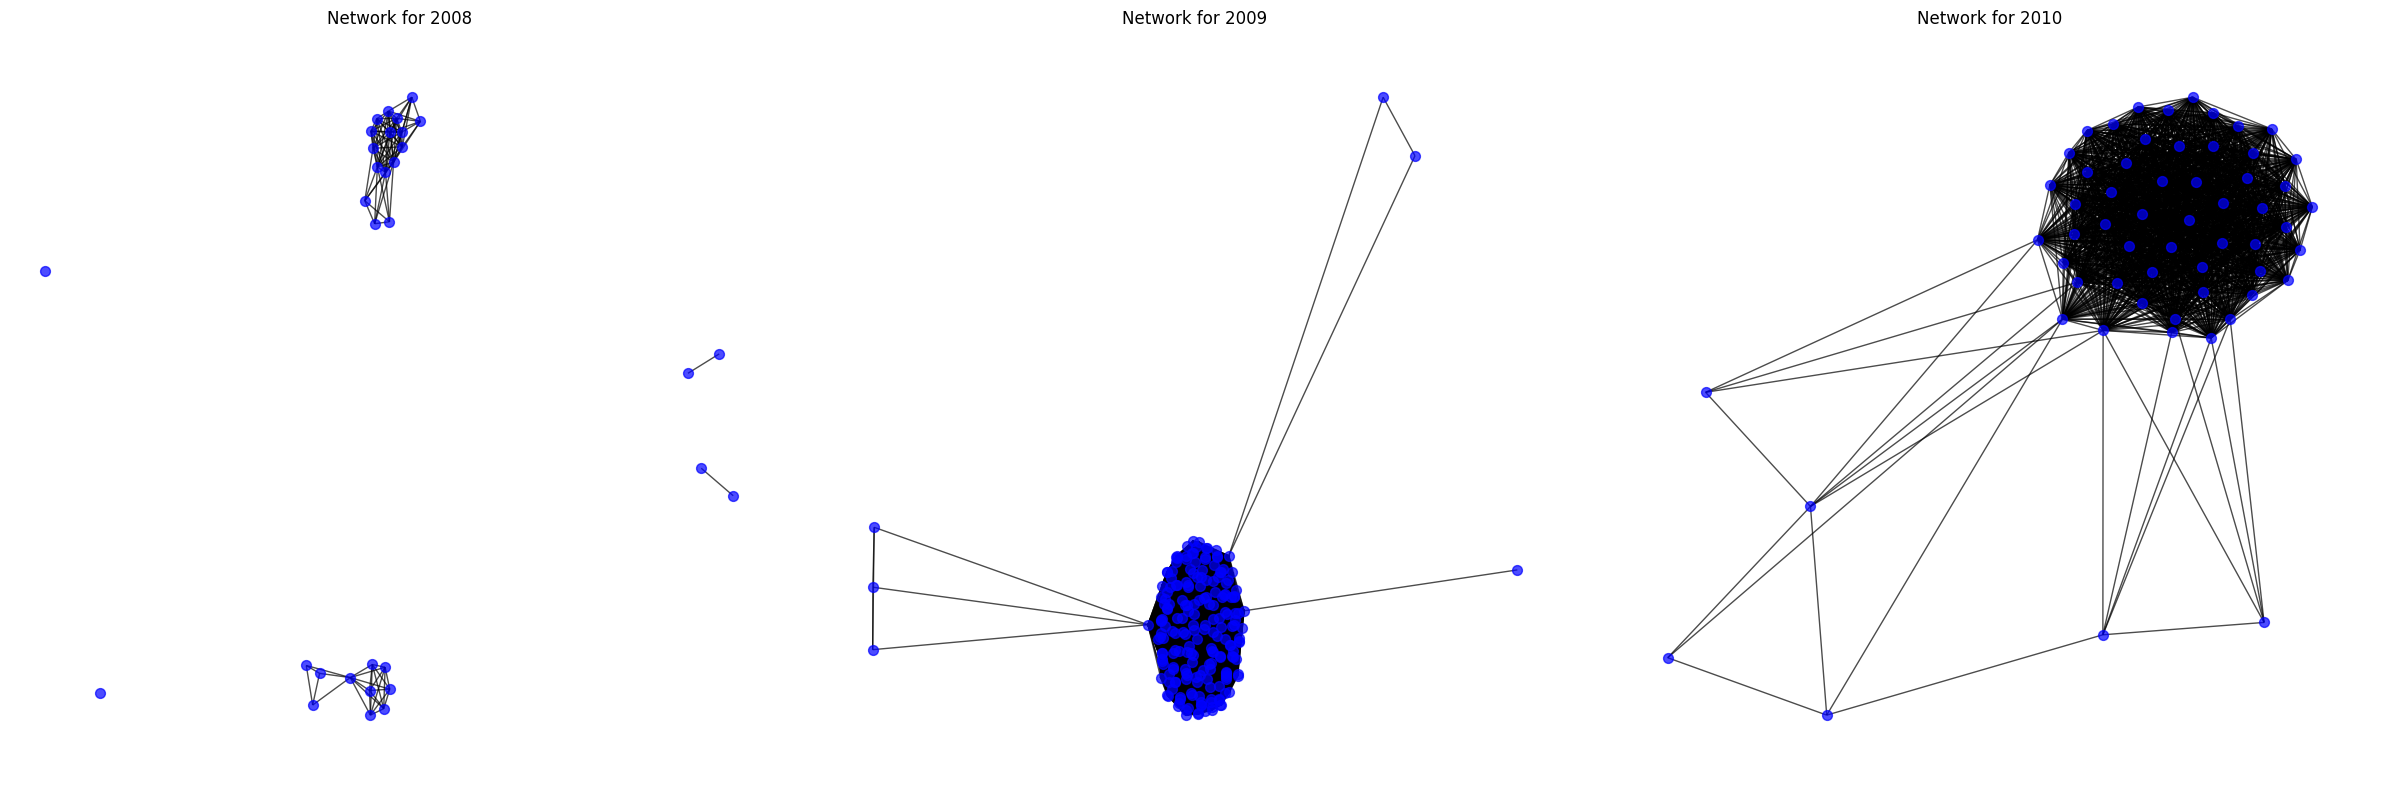

In [56]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
years = [2008, 2009, 2010]

for i, year in enumerate(years):
    ax = axes[i]
    G = yearly_networks[year]
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', alpha=0.7, node_size=50)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.7)
    ax.set_title(f'Network for {year}')
    ax.axis('off')

plt.tight_layout()
plt.show()

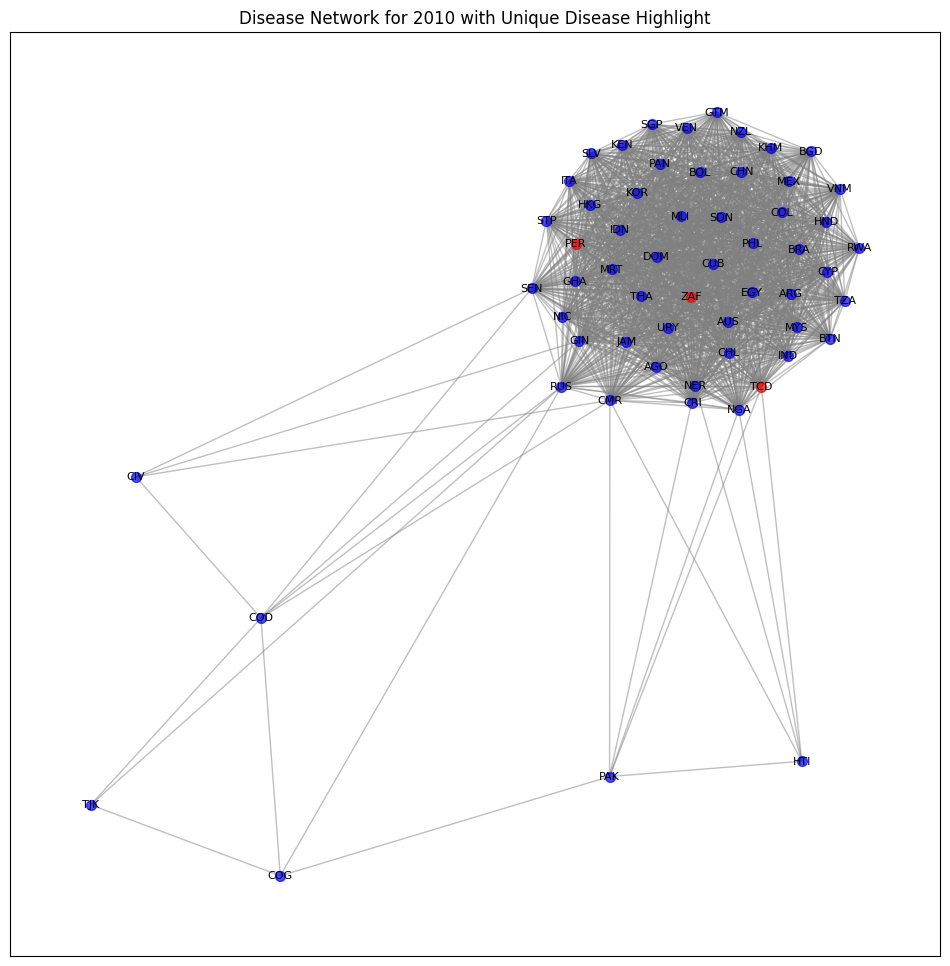

In [57]:
data_2010 = data_simplified_cleaned[data_simplified_cleaned['Year'] == 2010]

G_2010 = nx.Graph()
disease_counts = data_2010['Disease'].value_counts()
unique_diseases = disease_counts[disease_counts == 1].index.tolist()

# Add nodes with an attribute indicating whether the node has a unique disease
for _, row in data_2010.iterrows():
    if row['Disease'] in unique_diseases:
        G_2010.add_node(row['iso3'], has_unique_disease=True)
    elif row['iso3'] not in G_2010:
        G_2010.add_node(row['iso3'], has_unique_disease=False)

# Add edges between countries that share diseases
for disease, data in data_2010.groupby('Disease'):
    countries = data['iso3'].unique()
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            G_2010.add_edge(countries[i], countries[j])

# Layout for visualization
pos = nx.spring_layout(G_2010, seed=42)

# Draw the network
plt.figure(figsize=(12, 12))
for node, data in G_2010.nodes(data=True):
    color = 'red' if data.get('has_unique_disease', False) else 'blue'
    nx.draw_networkx_nodes(G_2010, pos, nodelist=[node], node_color=color, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_2010, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G_2010, pos, font_size=8)
plt.title("Disease Network for 2010 with Unique Disease Highlight")
plt.show()

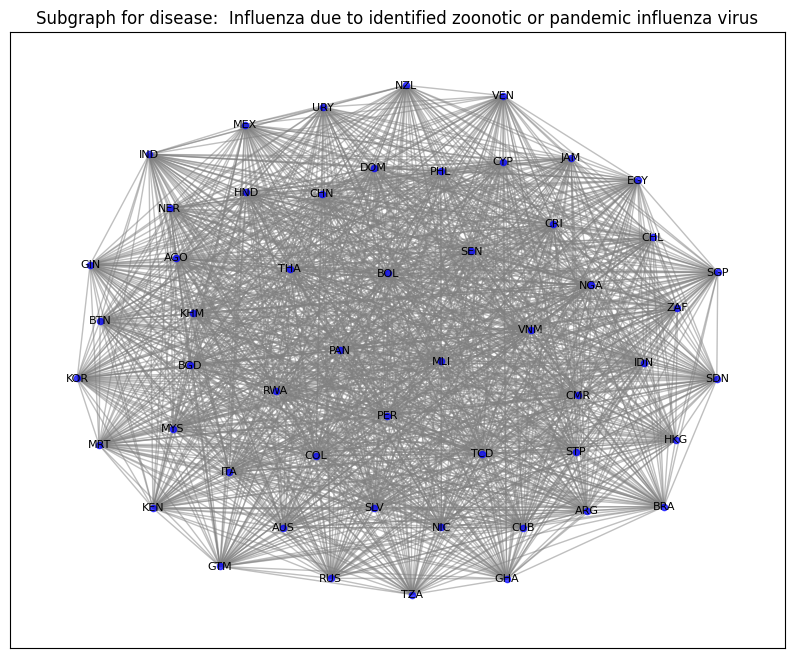

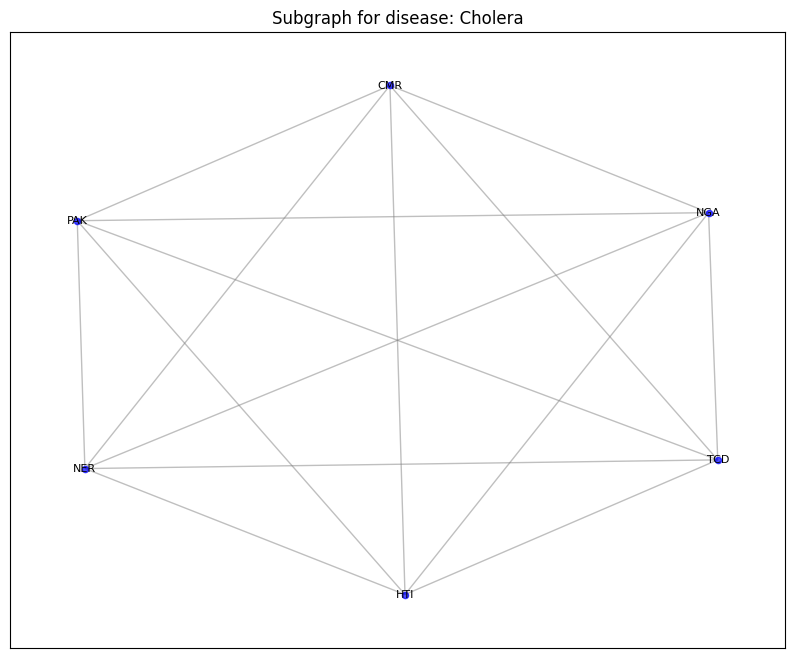

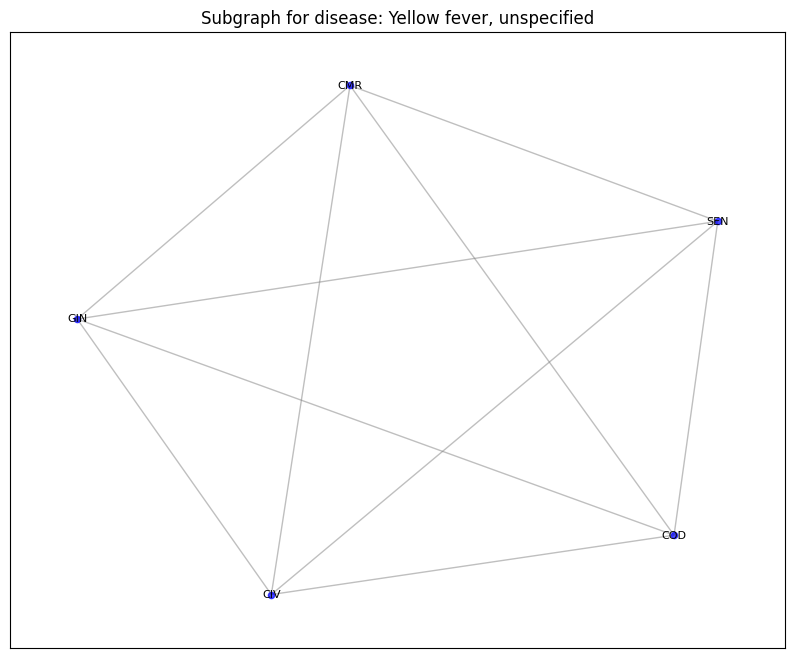

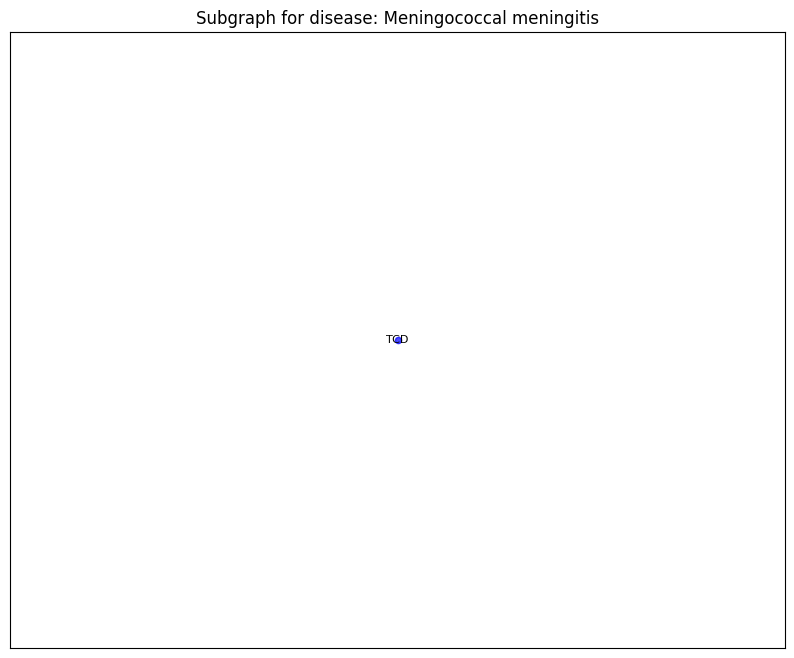

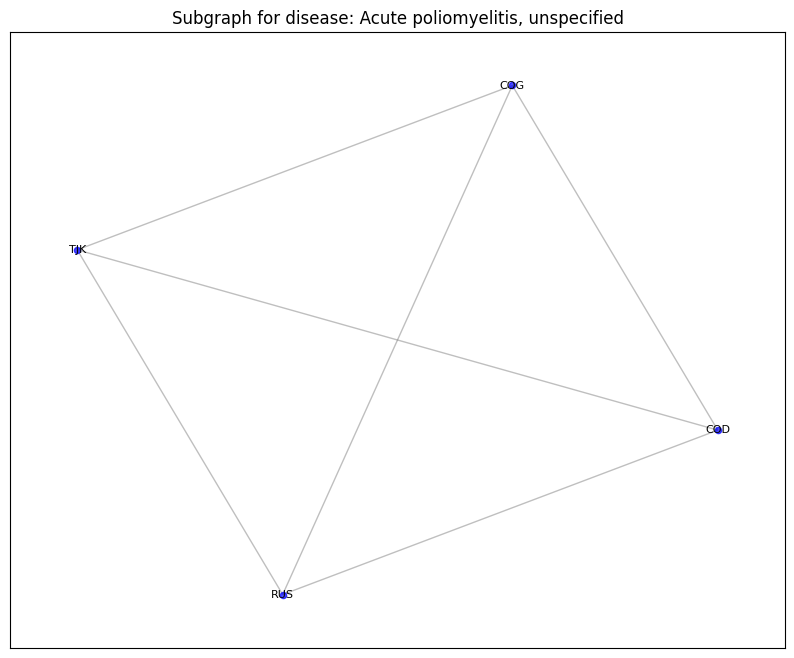

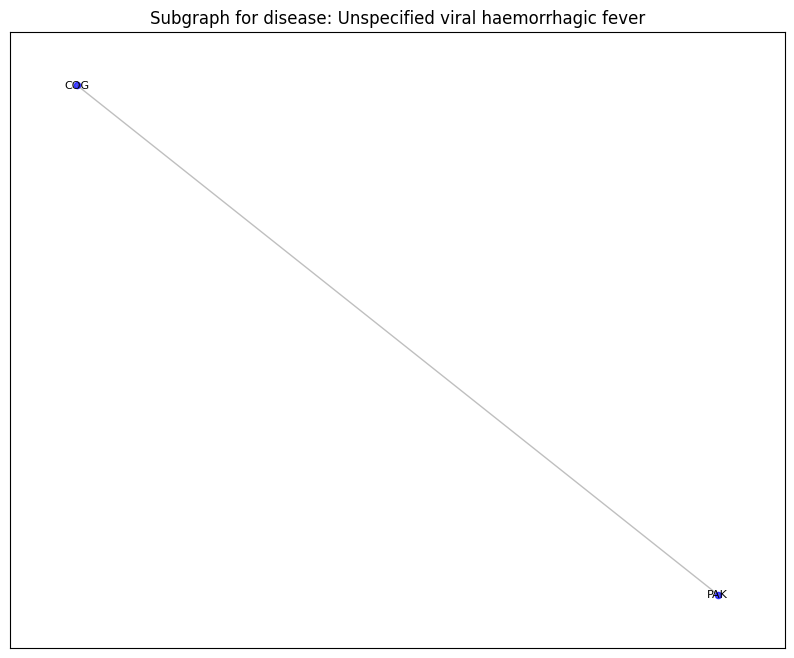

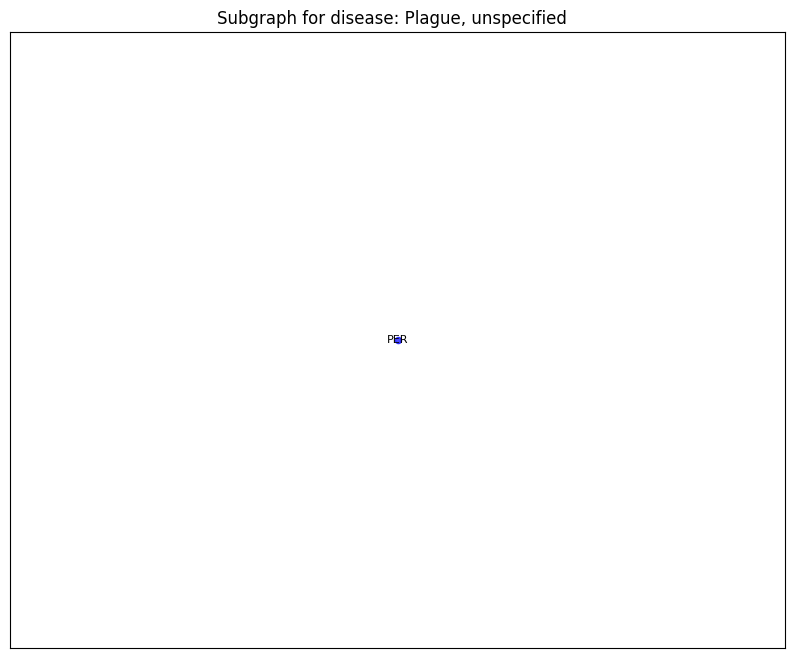

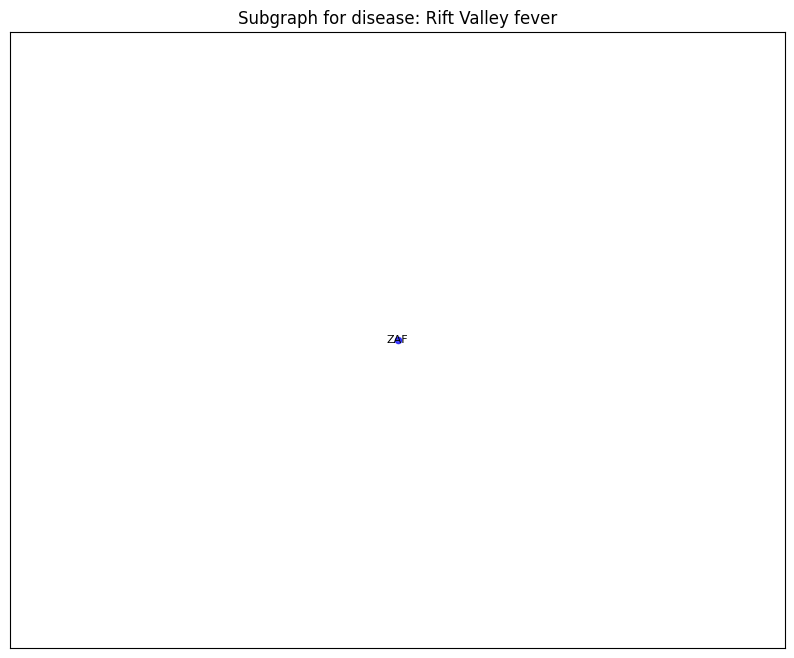

In [58]:
data_2010 = data_simplified_cleaned[data_simplified_cleaned['Year'] == 2010]

disease_subgraphs = {}

# Iterate through each disease, create a subgraph and visualize it
for disease in data_2010['Disease'].unique():
    # Get all countries that reported this disease
    countries_with_disease = data_2010[data_2010['Disease'] == disease]['iso3'].unique()
    # Create a subgraph for these countries
    H = nx.Graph()
    # Add nodes for all countries reporting the disease
    H.add_nodes_from(countries_with_disease)
    
    H.add_edges_from((country1, country2) for i, country1 in enumerate(countries_with_disease)
                     for country2 in countries_with_disease[i+1:])
    
    # Store the subgraph
    disease_subgraphs[disease] = H

# Visualize each subgraph
for disease, H in disease_subgraphs.items():
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(H, seed=42)  # For consistent layout
    nx.draw_networkx_nodes(H, pos, node_size=20, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(H, pos, edge_color='gray', alpha=0.5)
    nx.draw_networkx_labels(H, pos, font_size=8)
    plt.title(f"Subgraph for disease: {disease}")
    plt.show()

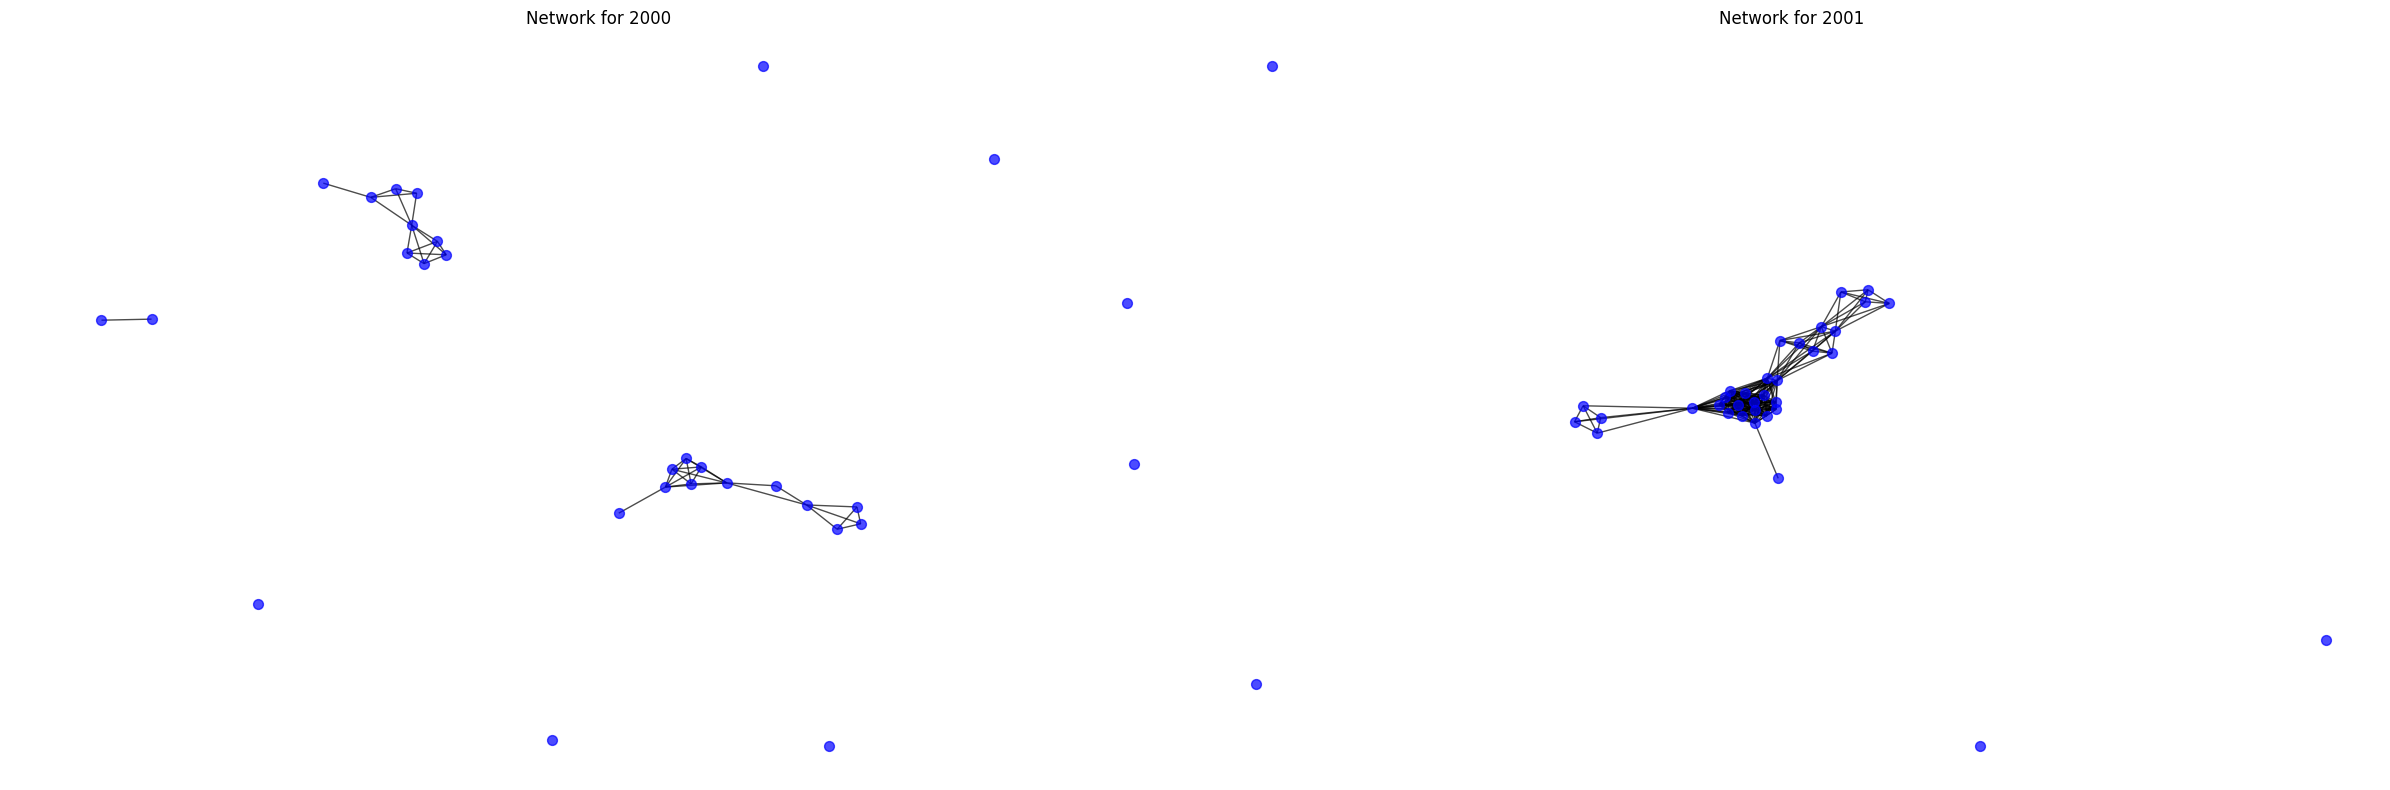

In [59]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
years = [2000, 2001]

for i, year in enumerate(years):
    ax = axes[i]
    G = yearly_networks[year]
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', alpha=0.7, node_size=50)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.7)
    ax.set_title(f'Network for {year}')
    ax.axis('off')

plt.tight_layout()
plt.show()

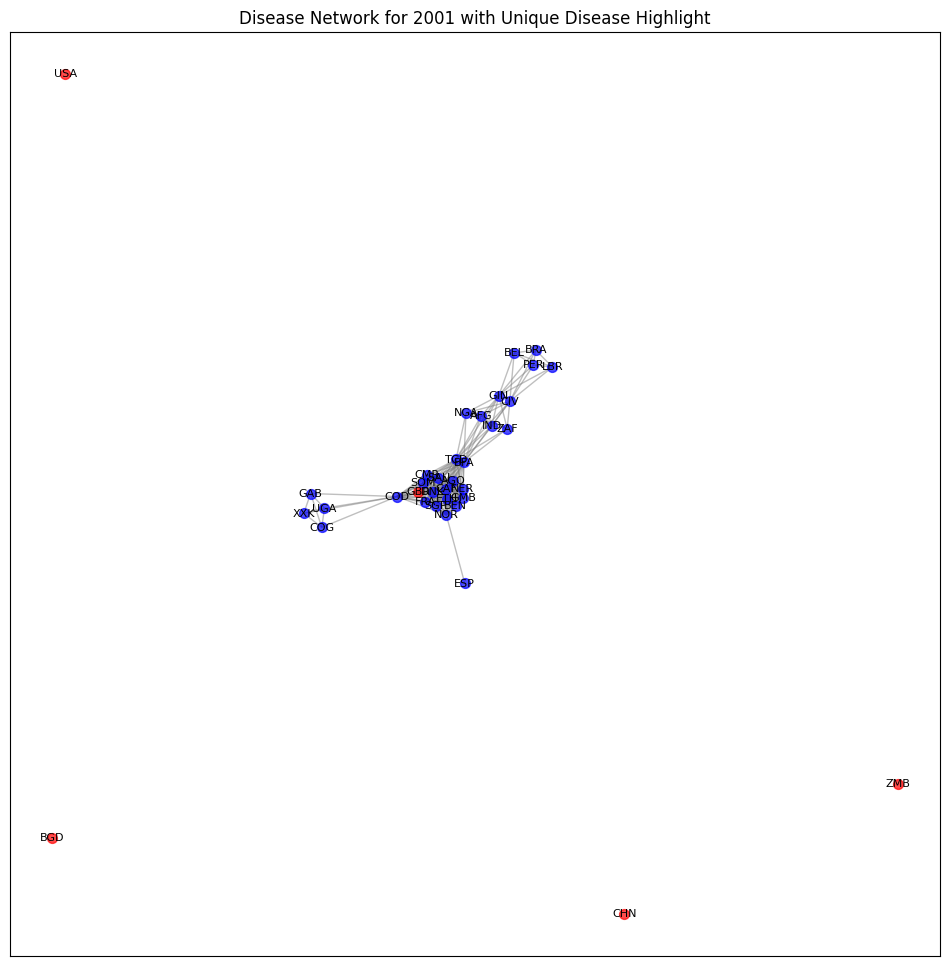

In [60]:
data_2001 = data_simplified_cleaned[data_simplified_cleaned['Year'] == 2001]

G_2001 = nx.Graph()

# Identify unique diseases
disease_counts = data_2001['Disease'].value_counts()
unique_diseases = disease_counts[disease_counts == 1].index.tolist()

# Add nodes with an attribute indicating whether the node has a unique disease
for _, row in data_2001.iterrows():
    if row['Disease'] in unique_diseases:
        G_2001.add_node(row['iso3'], has_unique_disease=True)
    elif row['iso3'] not in G_2001:
        G_2001.add_node(row['iso3'], has_unique_disease=False)

# Add edges between countries that share diseases
for disease, data in data_2001.groupby('Disease'):
    countries = data['iso3'].unique()
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            G_2001.add_edge(countries[i], countries[j])

# Layout for visualization
pos = nx.spring_layout(G_2001, seed=42)

# Draw the network
plt.figure(figsize=(12, 12))
for node, data in G_2001.nodes(data=True):
    color = 'red' if data.get('has_unique_disease', False) else 'blue'
    nx.draw_networkx_nodes(G_2001, pos, nodelist=[node], node_color=color, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_2001, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G_2001, pos, font_size=8)
plt.title("Disease Network for 2001 with Unique Disease Highlight")
plt.show()

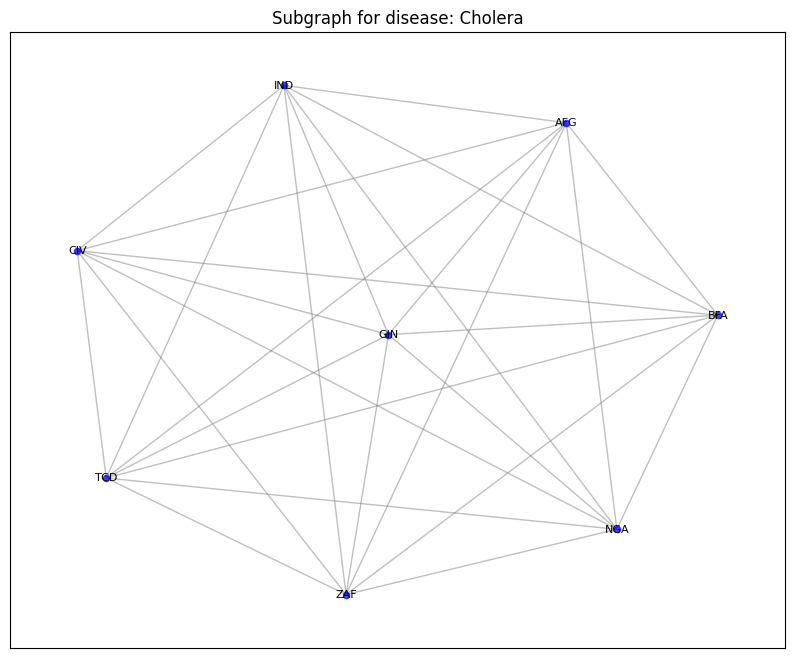

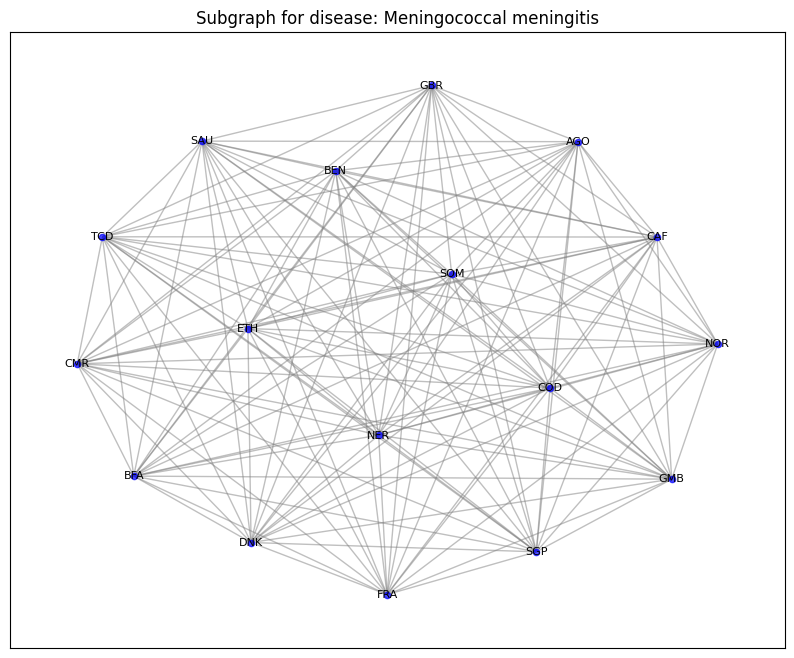

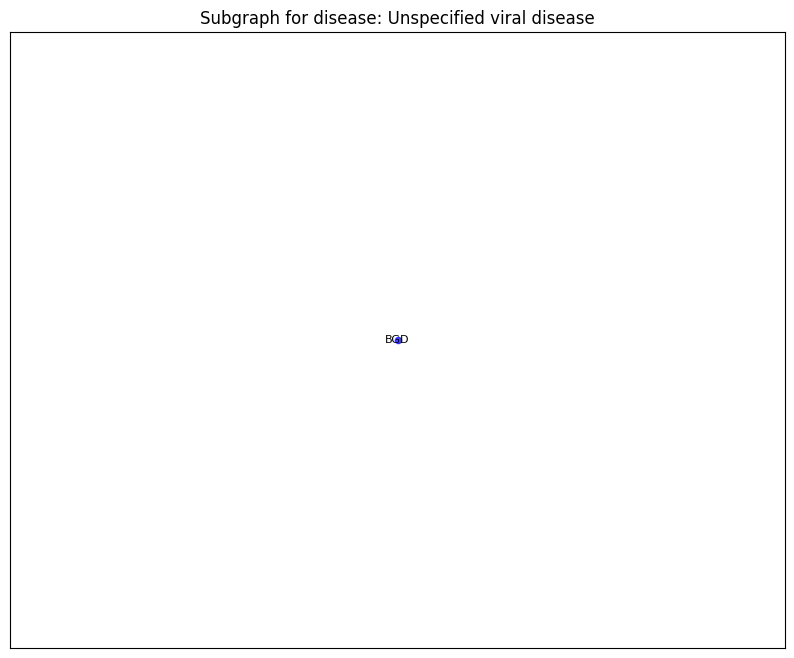

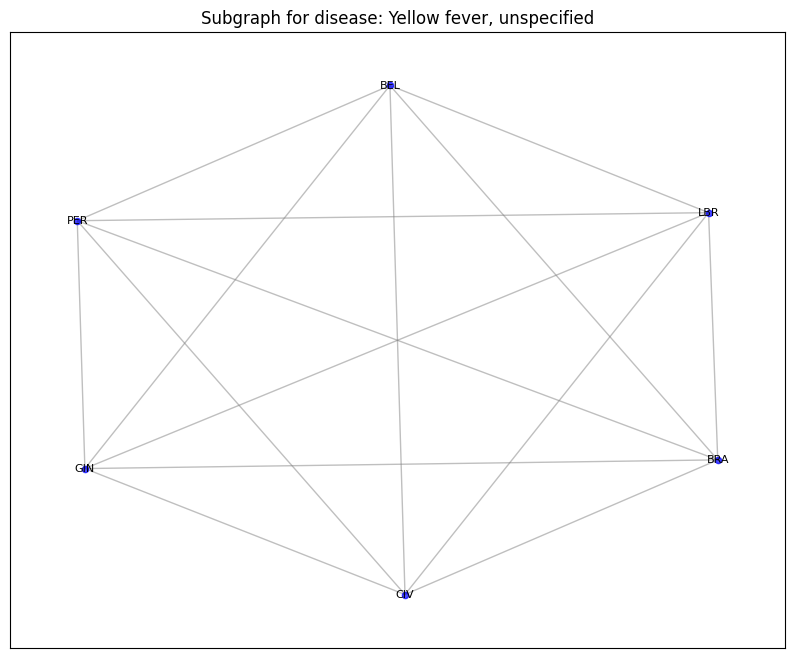

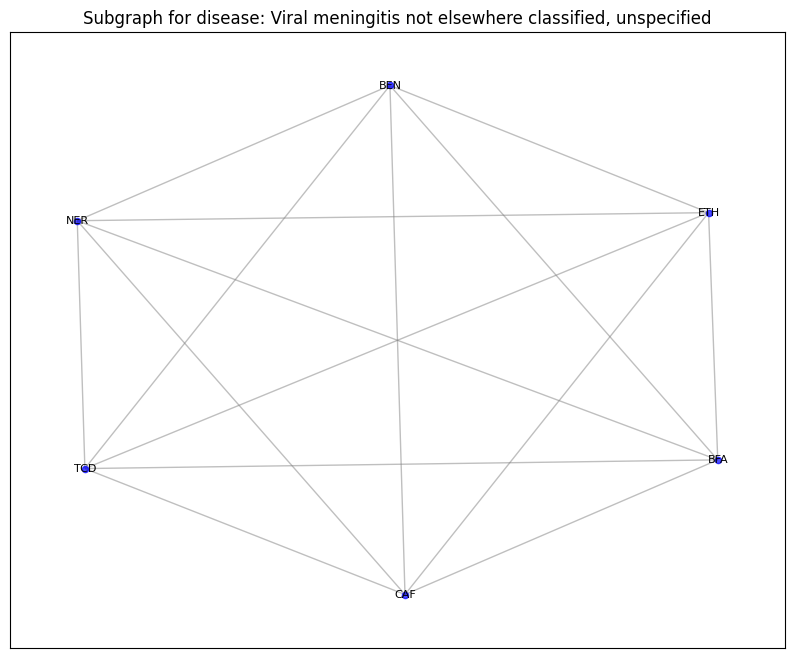

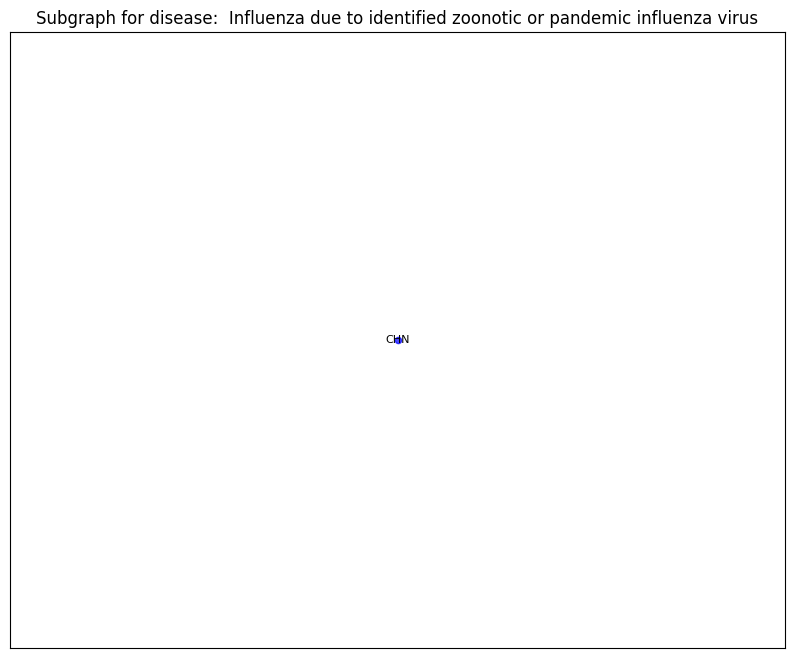

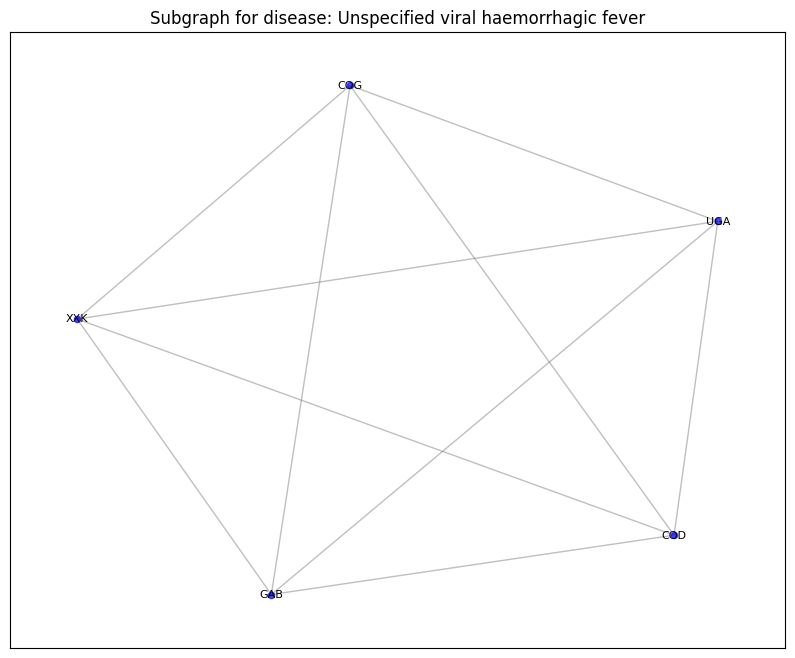

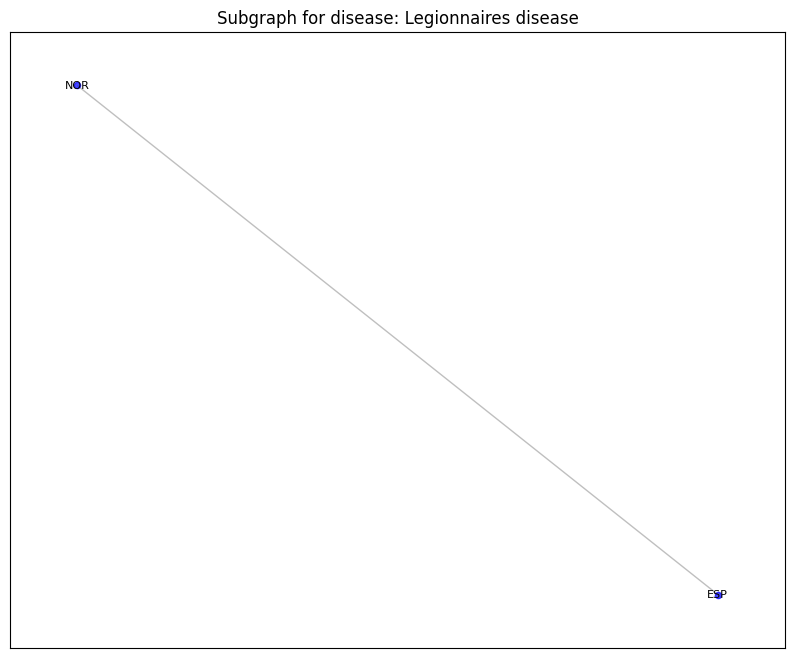

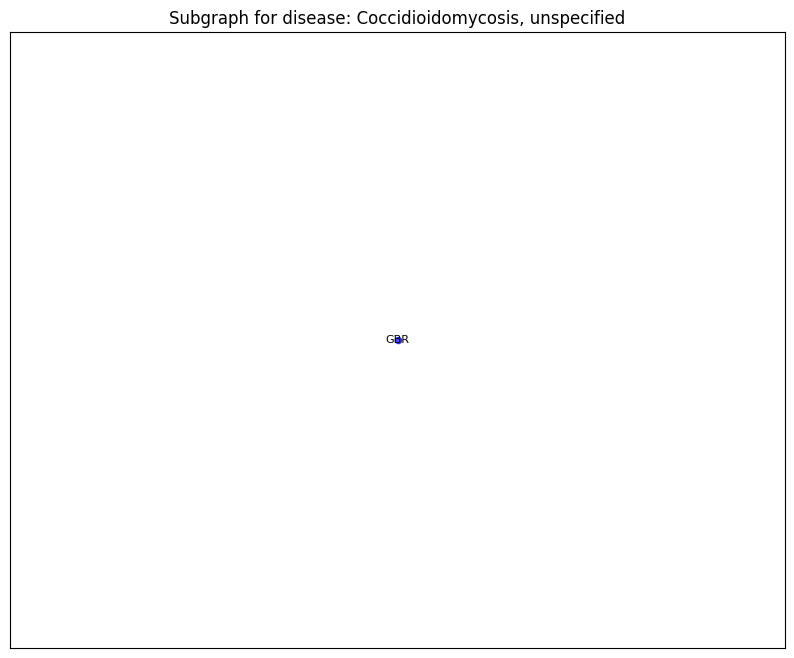

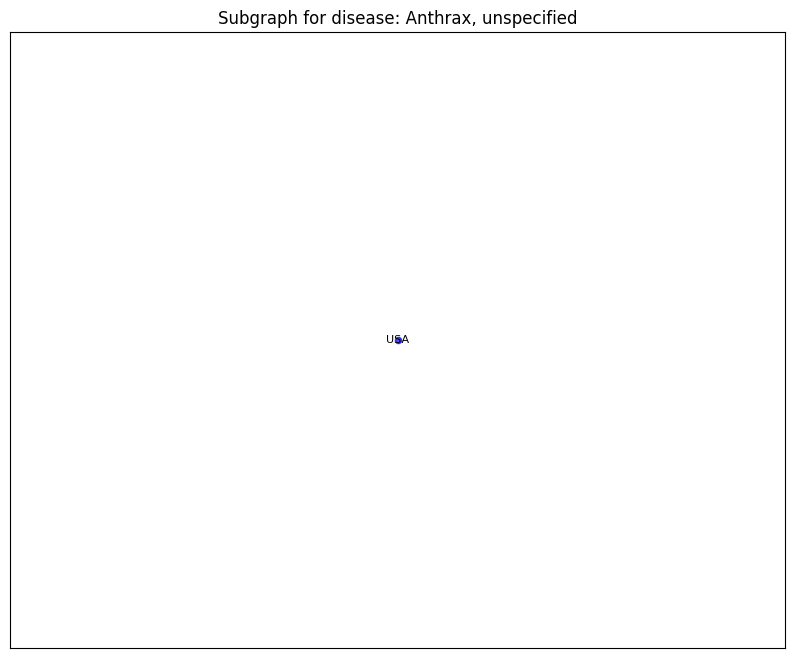

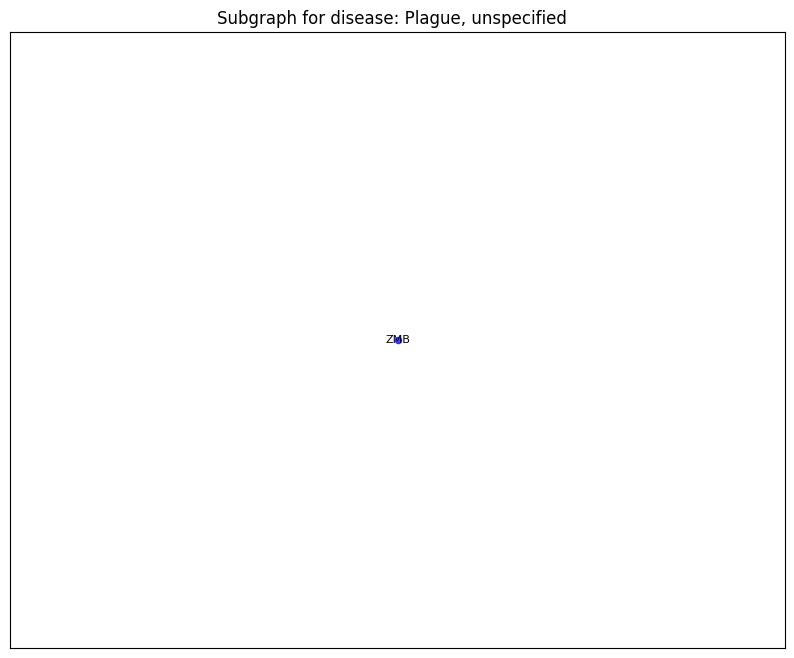

In [61]:
data_2001 = data_simplified_cleaned[data_simplified_cleaned['Year'] == 2001]

disease_subgraphs = {}

# Iterate through each disease, create a subgraph and visualize it
for disease in data_2001['Disease'].unique():
    # Get all countries that reported this disease
    countries_with_disease = data_2001[data_2001['Disease'] == disease]['iso3'].unique()
    # Create a subgraph for these countries
    H = nx.Graph()
    # Add nodes for all countries reporting the disease
    H.add_nodes_from(countries_with_disease)
    H.add_edges_from((country1, country2) for i, country1 in enumerate(countries_with_disease)
                     for country2 in countries_with_disease[i+1:])
    
    # Store the subgraph
    disease_subgraphs[disease] = H

# Visualize each subgraph
for disease, H in disease_subgraphs.items():
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(H, seed=42)  # For consistent layout
    nx.draw_networkx_nodes(H, pos, node_size=20, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(H, pos, edge_color='gray', alpha=0.5)
    nx.draw_networkx_labels(H, pos, font_size=8)
    plt.title(f"Subgraph for disease: {disease}")
    plt.show()

In [62]:
if 2001 in network_metrics:
    top_degree_2001 = sorted(network_metrics[2001]['degree'].items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness_2001 = sorted(network_metrics[2001]['betweenness'].items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top degree centrality nodes in 2001:", top_degree_2001)
    print("Top betweenness centrality nodes in 2001:", top_betweenness_2001)

if 2010 in network_metrics:
    top_degree_2010 = sorted(network_metrics[2010]['degree'].items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness_2010 = sorted(network_metrics[2010]['betweenness'].items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top degree centrality nodes in 2010:", top_degree_2010)
    print("Top betweenness centrality nodes in 2010:", top_betweenness_2010)


Top degree centrality nodes in 2001: [('BFA', 0.6285714285714286), ('TCD', 0.6285714285714286), ('COD', 0.5714285714285714), ('NOR', 0.4857142857142857), ('AGO', 0.45714285714285713)]
Top betweenness centrality nodes in 2001: [('COD', 0.18151260504201683), ('BFA', 0.16806722689075632), ('TCD', 0.16806722689075632), ('CIV', 0.08739495798319329), ('GIN', 0.08739495798319329)]
Top degree centrality nodes in 2010: [('CMR', 0.9655172413793103), ('RUS', 0.9482758620689655), ('TCD', 0.9310344827586207), ('GIN', 0.9310344827586207), ('NER', 0.9310344827586207)]
Top betweenness centrality nodes in 2010: [('RUS', 0.0679068360556564), ('CMR', 0.03455333736640449), ('GIN', 0.017443032869530174), ('SEN', 0.017443032869530174), ('TCD', 0.014892115345835854)]


In [63]:
# Network structure analysis for 2001
if 2001 in yearly_networks:
    density_2001 = nx.density(yearly_networks[2001])
    clustering_2001 = nx.average_clustering(yearly_networks[2001])
    components_2001 = nx.number_connected_components(yearly_networks[2001])
    print(f"Density (2001): {density_2001}, Clustering Coefficient (2001): {clustering_2001}, Connected Components (2001): {components_2001}")

# Network structure analysis for 2010
if 2010 in yearly_networks:
    density_2010 = nx.density(yearly_networks[2010])
    clustering_2010 = nx.average_clustering(yearly_networks[2010])
    components_2010 = nx.number_connected_components(yearly_networks[2010])
    print(f"Density (2010): {density_2010}, Clustering Coefficient (2010): {clustering_2010}, Connected Components (2010): {components_2010}")

Density (2001): 0.2984126984126984, Clustering Coefficient (2001): 0.8025989662212573, Connected Components (2001): 5
Density (2010): 0.8188194038573934, Clustering Coefficient (2010): 0.9688259312020105, Connected Components (2010): 1


## K-core Decomposition

In [64]:
aggregate_network = nx.Graph()

# Group data by 'Disease' and 'Year' to find connections between countries reporting the same disease in the same year
grouped_data = data_simplified_cleaned.groupby(['Disease', 'Year'])

for name, group in grouped_data:
    countries = group['Country'].unique()  # Get unique countries reporting the disease in this year
    # Create all possible pairs of countries
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if aggregate_network.has_edge(countries[i], countries[j]):
                aggregate_network[countries[i]][countries[j]]['weight'] += 1
            else:
                aggregate_network.add_edge(countries[i], countries[j], weight=1)

In [65]:
# Compute the k-core decomposition
k_core = nx.k_core(aggregate_network)
k_shell = nx.core_number(aggregate_network)  # This gives the core number for each node

# Find maximum core level
max_core_level = max(k_shell.values())

print("Maximum core level:", max_core_level)

Maximum core level: 221


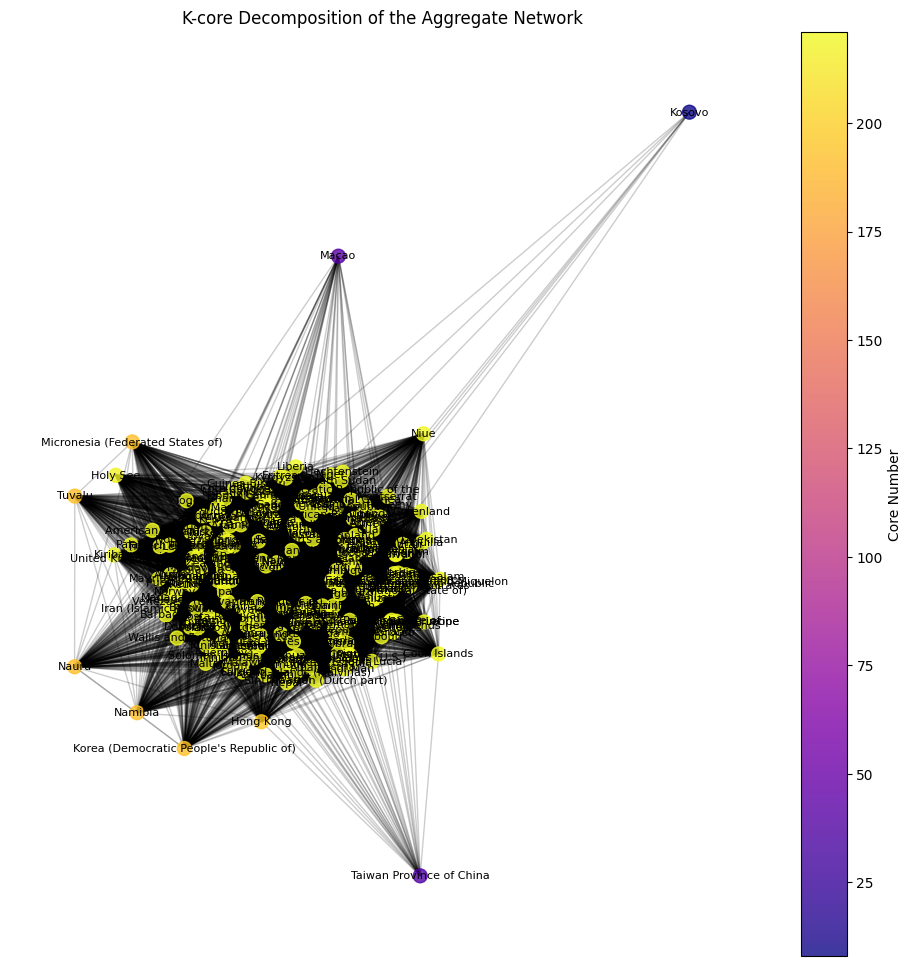

In [66]:
# Setting up the color map based on core number
core_colors = [k_shell[node] for node in aggregate_network.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(aggregate_network)  # Node position layout for visualization
nx.draw_networkx_edges(aggregate_network, pos, alpha=0.2)  # Draw edges lightly
nodes = nx.draw_networkx_nodes(aggregate_network, pos, node_color=core_colors, cmap=plt.cm.plasma, node_size=100, alpha=0.8)
nx.draw_networkx_labels(aggregate_network, pos, font_size=8, font_color='black')
plt.title('K-core Decomposition of the Aggregate Network')
plt.colorbar(nodes, label='Core Number')
plt.axis('off')  
plt.show()

In [67]:
aggregate_network = nx.Graph()
grouped_data = data_simplified_cleaned.groupby(['Disease', 'Year'])

for name, group in grouped_data:
    countries = group['iso3'].unique()  # Get unique countries reporting the disease in this year
    # Create all possible pairs of countries
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if aggregate_network.has_edge(countries[i], countries[j]):
                aggregate_network[countries[i]][countries[j]]['weight'] += 1
            else:
                aggregate_network.add_edge(countries[i], countries[j], weight=1)

In [68]:
report_counts = data_simplified_cleaned.groupby('iso3').size().reset_index(name='report_count')

degree_centrality = nx.degree_centrality(aggregate_network)
betweenness_centrality = nx.betweenness_centrality(aggregate_network)
closeness_centrality = nx.closeness_centrality(aggregate_network)


In [69]:

# Convert centrality dictionaries to DataFrame
centrality_df = pd.DataFrame({
    'iso3': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values())
})

# Merge with report counts
merged_df = pd.merge(report_counts, centrality_df, on='iso3')
centrality_df

iso3  degree_centrality  betweenness_centrality  closeness_centrality
0    CAN           0.991379            2.384489e-04              0.991453
1    CHN           0.995690            4.144839e-04              0.995708
2    HKG           0.883621            3.310861e-04              0.895753
3    IRN           0.987069            4.299550e-05              0.987234
4    ISR           0.991379            2.161598e-04              0.991453
..   ...                ...                     ...                   ...
228  PLW           0.956897            1.688643e-07              0.958678
229  NIU           0.952586            0.000000e+00              0.954733
230  TWN           0.159483            0.000000e+00              0.543326
231  MAC           0.176724            0.000000e+00              0.548463
232  XXK           0.034483            0.000000e+00              0.508772

[233 rows x 4 columns]

## Geospatial Analysis

In [71]:
## Merge distance data with current data
combined_data = data_simplified_cleaned.merge(geo_data, on='iso3', how='left')

combined_data.head()

Country_x iso3  Year                                            Disease  \
0  Afghanistan  AFG  2000               Unspecified viral haemorrhagic fever   
1  Afghanistan  AFG  2002  Infectious gastroenteritis or colitis without ...   
2  Afghanistan  AFG  1998                                            Cholera   
3  Afghanistan  AFG  1999                  Severe acute respiratory syndrome   
4  Afghanistan  AFG  2000                                            Cholera   

     Country_y iso2  Numeric code   lat   lon  
0  Afghanistan   AF           4.0  33.0  65.0  
1  Afghanistan   AF           4.0  33.0  65.0  
2  Afghanistan   AF           4.0  33.0  65.0  
3  Afghanistan   AF           4.0  33.0  65.0  
4  Afghanistan   AF           4.0  33.0  65.0

In [72]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    return c * r


In [73]:
# Calculate distances between all pairs of countries
country_distances = {}

# Only add one direction since the distance is symmetric
for (index1, row1), (index2, row2) in combinations(geo_data.iterrows(), 2):
    dist = haversine(row1['lon'], row1['lat'], row2['lon'], row2['lat'])
    # Create a sorted tuple of country codes to ensure consistency
    country_pair = tuple(sorted([row1['iso3'], row2['iso3']]))
    country_distances[country_pair] = dist
distances_df = pd.DataFrame(list(country_distances.items()), columns=['Country_Pair', 'Distance'])
print(distances_df.head())

  Country_Pair      Distance
0   (AFG, ALB)   4047.637966
1   (AFG, DZA)   5881.179067
2   (AFG, ASM)  14114.458021
3   (AFG, AND)   5542.850159
4   (AFG, AGO)   7064.158778


In [74]:
G = nx.Graph()

# Add edges based on the country distances
for (country1, country2), distance in country_distances.items():
    # Use the inverse of the distance as the weight
    weight = 1 / distance if distance != 0 else 0
    G.add_edge(country1, country2, weight=weight, distance=distance)  # Store distance as an attribute


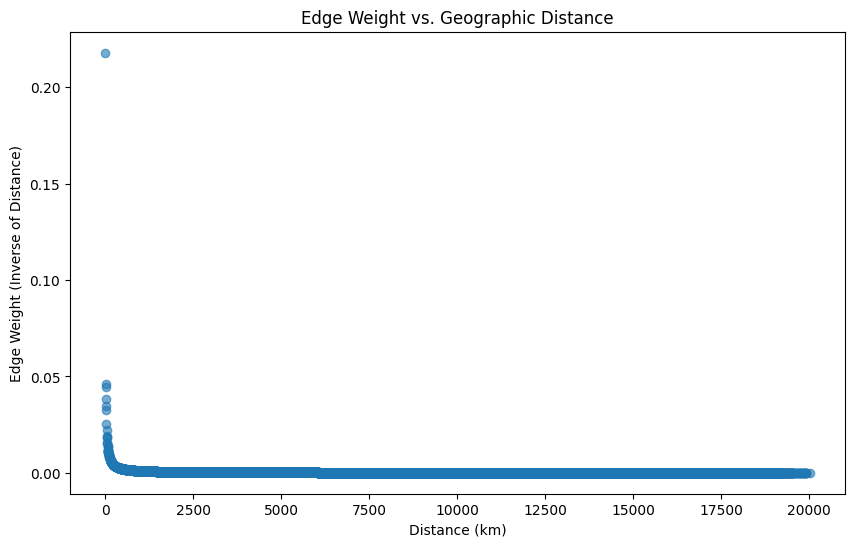

In [75]:
distances = []
weights = []

for u, v, data in G.edges(data=True):
    if 'distance' in data and 'weight' in data:  # Ensure the edge has both attributes
        distances.append(data['distance'])
        weights.append(data['weight'])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(distances, weights, alpha=0.6)
plt.title('Edge Weight vs. Geographic Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Edge Weight (Inverse of Distance)')
plt.grid(False)
plt.show()

In [76]:
# Calculate total and average weight of the network
total_weight = sum(data['weight'] for u, v, data in G.edges(data=True))
average_weight = total_weight / G.number_of_edges()

print(f"Total weight of the network: {total_weight}")
print(f"Average weight of the network: {average_weight}")


Total weight of the network: 7.70883142797089
Average weight of the network: 0.000247673298890631


In [77]:
# Calculate the strength of each node
strengths = {node: sum(data['weight'] for neighbor, data in G[node].items()) for node in G.nodes()}

# Sort by top connected nodes
sorted_strengths = sorted(strengths.items(), key=lambda item: item[1], reverse=True)

# Display the top 5 nodes with their strengths
print("Top 5 nodes by connection strength:")
for node, strength in sorted_strengths[:5]:
    print(f"Node {node}: Strength {strength}")


Top 5 nodes by connection strength:
Node MAF: Strength 0.38917642069796254
Node SXM: Strength 0.38591554011314744
Node AIA: Strength 0.1931286642527195
Node BLM: Strength 0.18652983557422903
Node KNA: Strength 0.1417460269501759


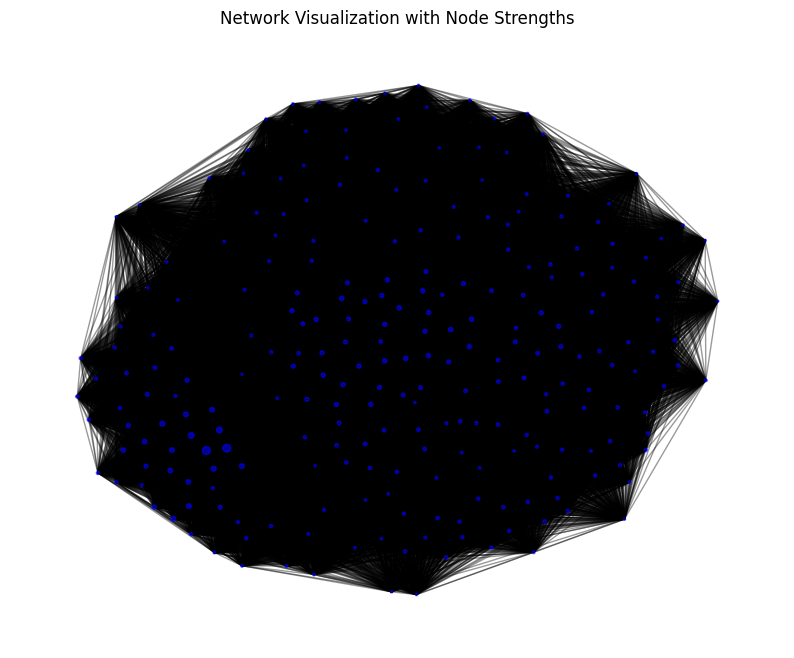

In [78]:
# Node size proportional to the log of their strength for better visualization
node_sizes = [np.log(strengths[node] + 1) * 100 for node in G.nodes()]

# Draw the network
pos = nx.spring_layout(G) 
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=1)
plt.title('Network Visualization with Node Strengths')
plt.axis('off')  
plt.show()

In [ ]:
## Calculating Spatial Degree

In [79]:
spatial_degrees = {}

for node in G.nodes():
    # Get all the weights of the edges connected to the current node
    weights = [data['weight'] for neighbor, data in G[node].items()]
    if weights:  # Ensure there are connected edges
        spatial_degree = sum(weights) / len(weights)
    else:
        spatial_degree = 0  # Node has no connections
    
    
    spatial_degrees[node] = spatial_degree

print("Spatial Degrees of Nodes:")
for node, degree in spatial_degrees.items():
    print(f"Node {node}: {degree}")

sorted_spatial = sorted(spatial_degrees.items(), key=lambda item: item[1], reverse=True)

    
print("Top 5 nodes by connection strength:")
for node, strength in sorted_spatial[:5]:
    print(f"Node {node}: Strength {sorted_spatial}")


Spatial Degrees of Nodes:
Node AFG: 0.00020428969238303415
Node ALB: 0.0003960680967024966
Node DZA: 0.0002346746351802766
Node ASM: 0.0001334650578584487
Node AND: 0.00029503108780320493
Node AGO: 0.00018008958342057382
Node AIA: 0.0007756171255129296
Node ATA: 9.105370147573351e-05
Node ATG: 0.0005191366967439467
Node ARG: 0.0001233535814496919
Node ARM: 0.00027049824046091115
Node ABW: 0.0003148243290637147
Node AUS: 0.00010189718404066224
Node AUT: 0.0003920592418947612
Node AZE: 0.000257377200040945
Node BHS: 0.00021021141963120391
Node BHR: 0.00027803491408413475
Node BGD: 0.0001713138209591369
Node BRB: 0.0003320397529117657
Node BLR: 0.00028985487187671387
Node BEL: 0.00034483449103963097
Node BLZ: 0.00019777928800768842
Node BEN: 0.000241248143083524
Node BMU: 0.00018000080057334398
Node BTN: 0.0001720324963082851
Node BOL: 0.0001395466551072948
Node BIH: 0.0004069814063629507
Node BWA: 0.00017591500248020477
Node BVT: 0.00011053893695643912
Node BRA: 0.00014988252197488248
No

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/var/folders/3n/6lwyw3ds0g1btn8kl6pjc7880000gn/T/ipykernel_70220/1839134233.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Spatial Degree')


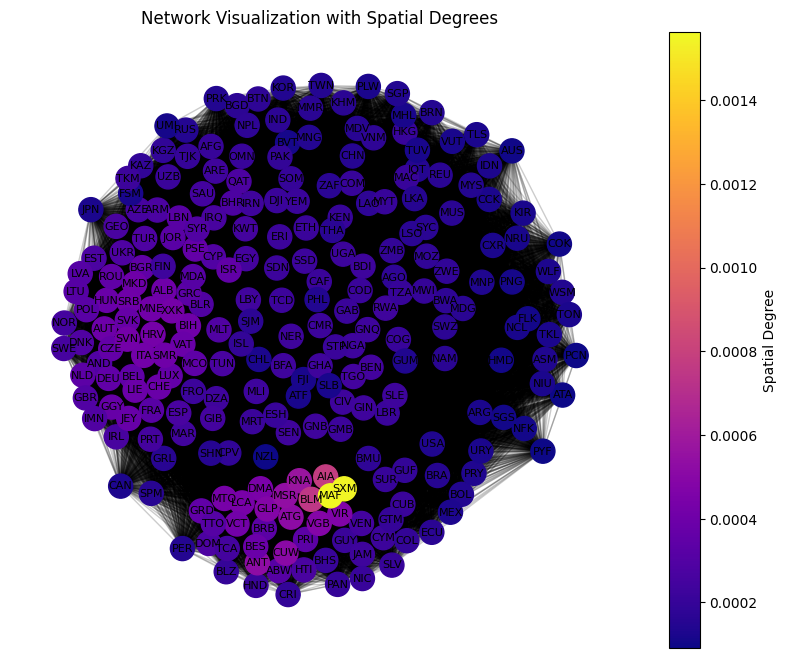

In [80]:
pos = nx.spring_layout(G) 
norm = plt.Normalize(min(spatial_degrees.values()), max(spatial_degrees.values()))
node_colors = [plt.cm.plasma(norm(spatial_degrees[node])) for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors, cmap=plt.cm.plasma)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Spatial Degree')
plt.title('Network Visualization with Spatial Degrees')
plt.axis('off')
plt.show()

In [81]:
# Compute the weighted clustering coefficient for each node
node_clustering = nx.clustering(G, weight='weight')
print("Node weighted clustering coefficients:")
for node, coeff in node_clustering.items():
    print(f"{node}: {coeff}")

# Compute the average weighted clustering coefficient for the network
average_clustering = nx.average_clustering(G, weight='weight')
print(f"\nAverage weighted clustering coefficient of the network: {average_clustering}")

Node weighted clustering coefficients:
AFG: 0.0007929250615317936
ALB: 0.001073384685045694
DZA: 0.0008941821528884202
ASM: 0.0005056946227920755
AND: 0.0009762424156609112
AGO: 0.0007387847243911392
AIA: 0.0009953546446764654
ATA: 0.0004936794492114215
ATG: 0.0009495671715656148
ARG: 0.0005704064350404983
ARM: 0.0009115104241094856
ABW: 0.0008204903595579936
AUS: 0.000508470055871292
AUT: 0.0010799454782985912
AZE: 0.0008936078328086604
BHS: 0.0007420802501400085
BHR: 0.0008704844439163784
BGD: 0.0006885605568199696
BRB: 0.0008589057855156122
BLR: 0.000960557376317325
BEL: 0.001010683638836497
BLZ: 0.0006807808842551992
BEN: 0.0008459261031704836
BMU: 0.0007319590447809292
BTN: 0.0006920447621449516
BOL: 0.0006174818224400773
BIH: 0.001094847075805827
BWA: 0.0007041281711458086
BVT: 0.0005624474050370023
BRA: 0.0006542161810223561
IOT: 0.0006532680022021497
BRN: 0.0005975003309876751
BGR: 0.0010409783817879974
BFA: 0.0008467859500810318
BDI: 0.0007981738998449726
KHM: 0.00063996650856

/var/folders/3n/6lwyw3ds0g1btn8kl6pjc7880000gn/T/ipykernel_70220/1931870427.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Weighted Clustering Coefficient')


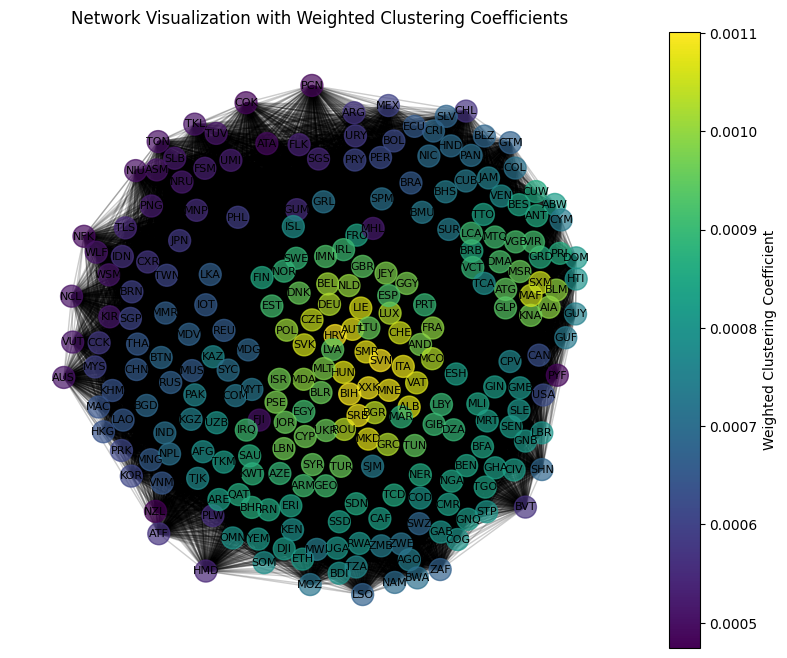

In [82]:
# Use a color map to represent clustering coefficients
pos = nx.spring_layout(G)  # positions for all nodes
clust_coeff_values = list(node_clustering.values())
norm = plt.Normalize(min(clust_coeff_values), max(clust_coeff_values))
node_colors = [plt.cm.viridis(norm(coeff)) for coeff in clust_coeff_values]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=250, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Weighted Clustering Coefficient')
plt.title('Network Visualization with Weighted Clustering Coefficients')
plt.axis('off')  # Turn off the axis
plt.show()

In [83]:
clustering_coeffs = nx.clustering(G, weight='weight')  


geo_data.set_index('iso3', inplace=True) 

In [84]:
coeff_df = pd.DataFrame.from_dict(clustering_coeffs, orient='index', columns=['Clustering_Coefficient'])
coeff_df['iso3'] = coeff_df.index

merged_data = coeff_df.merge(geo_data, left_on='iso3', right_index=True)


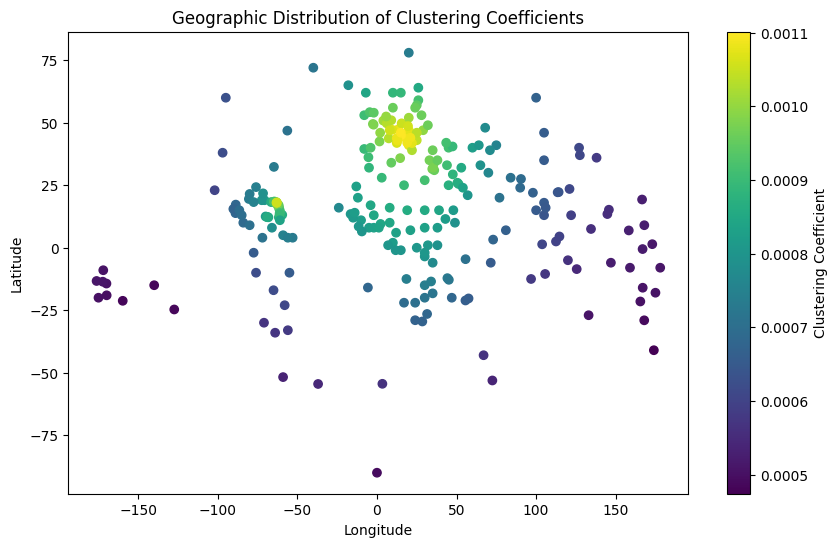

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sc = plt.scatter(merged_data['lon'], merged_data['lat'], c=merged_data['Clustering_Coefficient'], cmap='viridis')
plt.colorbar(sc, label='Clustering Coefficient')
plt.title('Geographic Distribution of Clustering Coefficients')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.show()


In [86]:
def visualize_disease_network(disease, data_2010, country_distances):
    disease_data = data_2010[data_2010['Disease'] == disease]
    countries = disease_data['iso3'].unique()
    
    # Create a network for the disease
    G = nx.Graph()
    for country1 in countries:
        for country2 in countries:
            if country1 != country2:
                # Check if the distance data exists
                pair = tuple(sorted([country1, country2]))
                if pair in country_distances:
                    # Add an edge with the inverse of distance as weight
                    distance = country_distances[pair]
                    weight = 1 / distance if distance != 0 else float('inf')
                    G.add_edge(country1, country2, weight=weight)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw(G, pos, with_labels=True, node_color='lightyellow', edge_color=edge_colors,
            edge_cmap=plt.cm.Blues, width=4, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors))
    plt.title(f"Weighted Distance Network for {disease} (2010)")
    plt.show()

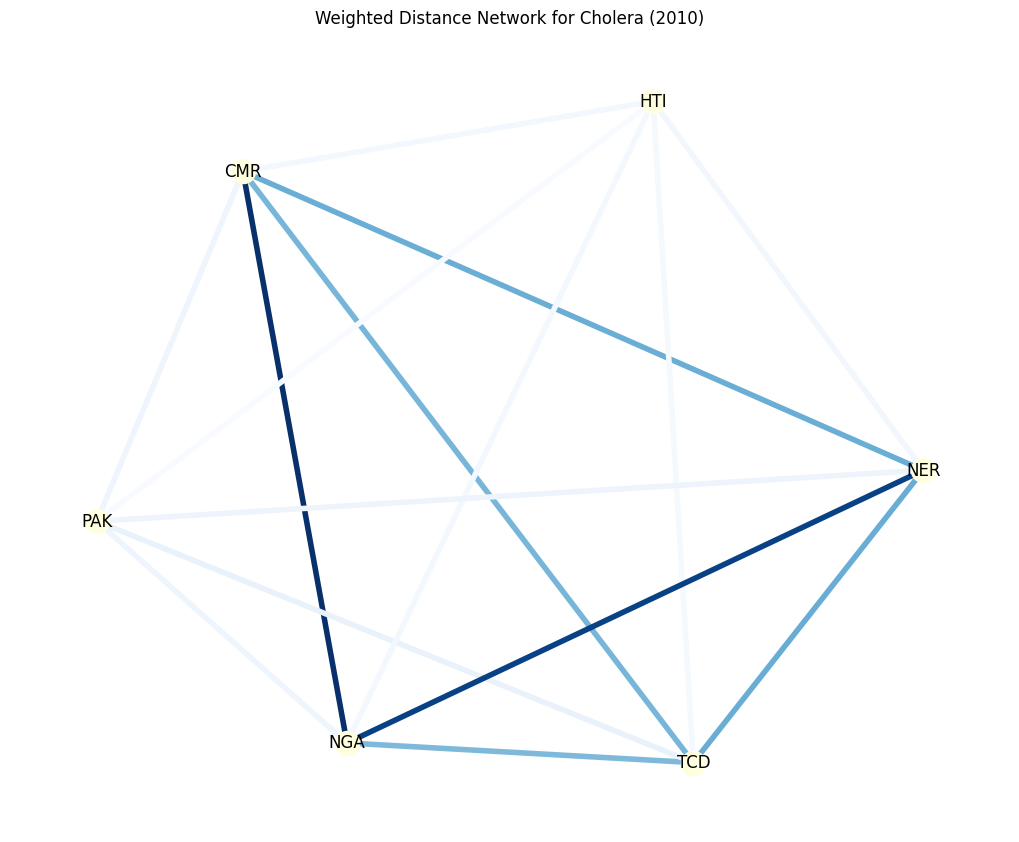

In [87]:
visualize_disease_network('Cholera', data_2010, country_distances)

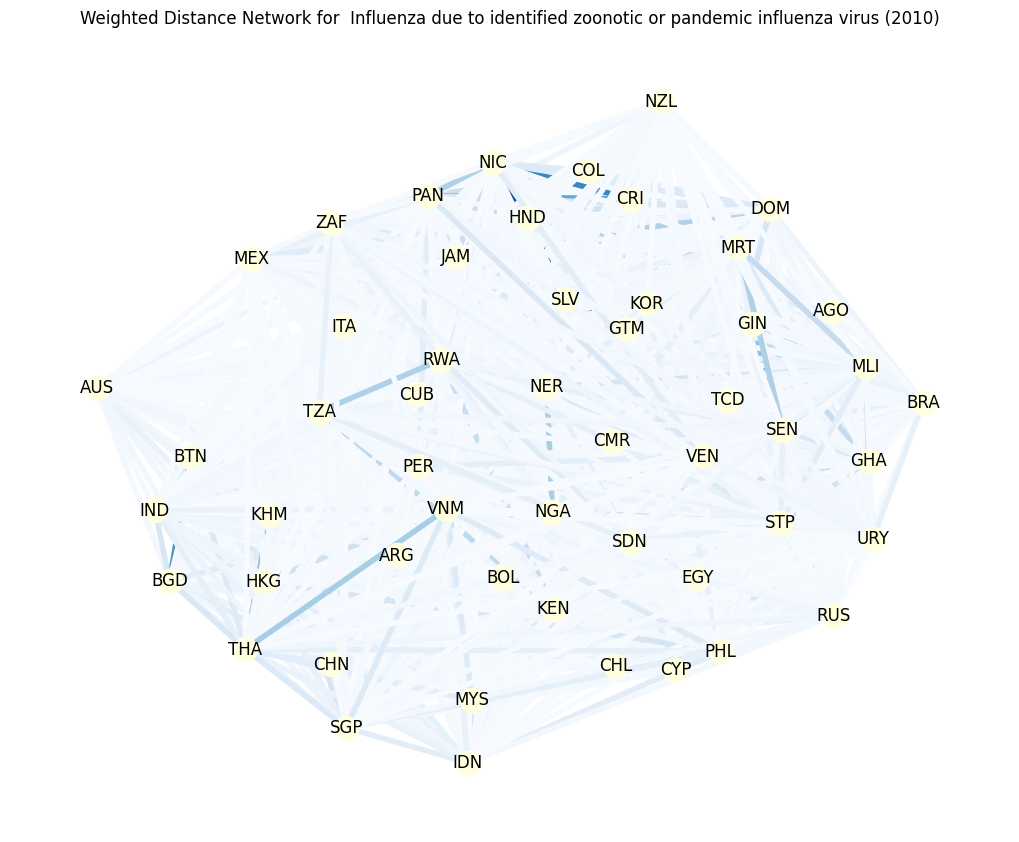

In [88]:
visualize_disease_network(' Influenza due to identified zoonotic or pandemic influenza virus', data_2010, country_distances)

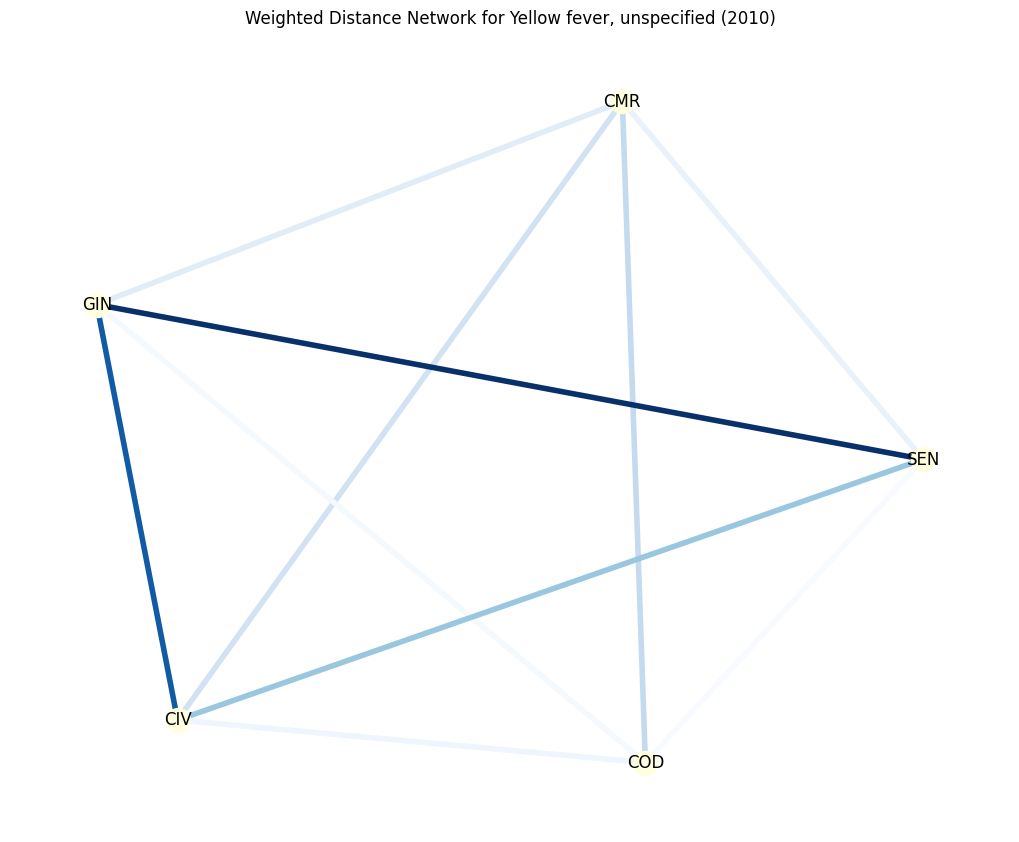

In [89]:
visualize_disease_network('Yellow fever, unspecified', data_2010, country_distances)

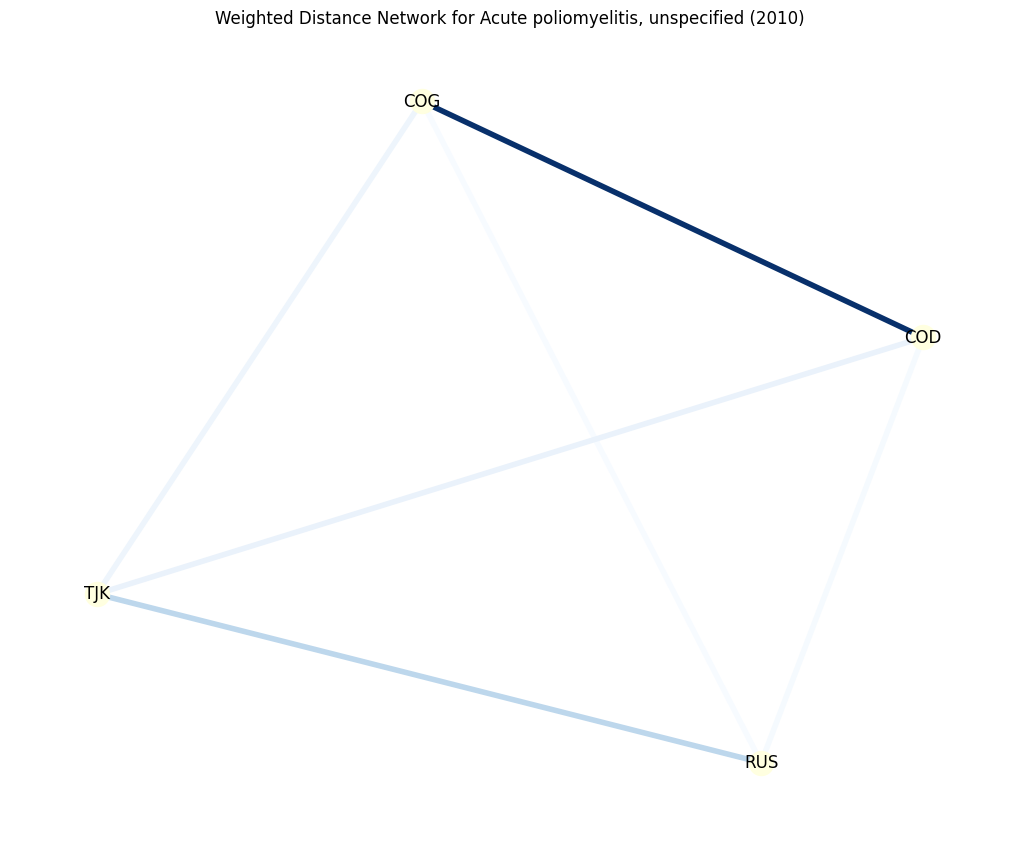

In [90]:
visualize_disease_network('Acute poliomyelitis, unspecified', data_2010, country_distances)